# Text Preprocessing and Sentiment Analysis

## Importing the required Libraries

In [ ]:
import pandas as pd
import json
import gzip
import re
import spacy                                                 
from spacy.lang.en import English                             # Import specific model
nlp = spacy.load("en_core_web_sm")                            # Load model
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import recall_score,precision_score,accuracy_score,f1_score,classification_report,plot_confusion_matrix
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.tree import DecisionTreeClassifier
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler

## Loading the Datafile which we used for EDA

In [5]:
df_final=pd.read_csv('finally_done.csv')
df_final.head()

,reviewTime,reviewerID,product_id,reviewText,summary,rating,main_cat,title,rank_no,price,reviewerName,verified,year,month
0,2018-01-05,A2HOI48JK8838M,B00004U9V2,This handcream has a beautiful fragrance. It d...,Beautiful Fragrance,5.0,Luxury Beauty,Crabtree &amp; Evelyn - Gardener's Ultra-Moist...,4324.0,30.0,DB,True,2018,1
1,2018-01-05,A2HOI48JK8838M,B00004U9V2,This handcream has a beautiful fragrance. It d...,Beautiful Fragrance,3.0,Luxury Beauty,Crabtree &amp; Evelyn - Gardener's Ultra-Moist...,4324.0,30.0,DB,True,2018,1
2,2016-08-14,A2HOI48JK8838M,B00004U9V2,There is no evidence to me that this product i...,Paying for the name,5.0,Luxury Beauty,Crabtree &amp; Evelyn - Gardener's Ultra-Moist...,4324.0,30.0,DB,True,2016,8
3,2016-08-14,A2HOI48JK8838M,B00004U9V2,There is no evidence to me that this product i...,Paying for the name,3.0,Luxury Beauty,Crabtree &amp; Evelyn - Gardener's Ultra-Moist...,4324.0,30.0,DB,True,2016,8
4,2017-04-05,A1YIPEY7HX73S7,B00004U9V2,"wonderful hand lotion, for seriously dry skin,...",wonderful hand lotion,5.0,Luxury Beauty,Crabtree &amp; Evelyn - Gardener's Ultra-Moist...,4324.0,30.0,Ajaey,True,2017,4


## Checking the shape of our dataframe

In [6]:
df_final.shape

(23349, 14)

## Defining functions for modular coding purpose

In [7]:
def null_values(df):
    print(f"Total null values with repect too each column are:- {df.isnull().sum()}")

In [8]:
def per_null(df,col):
    null=df[col].isnull().sum()
    total=len(df)
    percent=(null/total)*100
    print(f"Percentage of null values are {round(percent,2)}")

In [9]:
def val_count(df,col):
    print(f"Counts of each category are {df[col].value_counts()}")

In [10]:
def n_unq(df,col):
    print(f"No. of unique values are {df[col].nunique()}")

## We are removing some words from the stopwords so that we can proceed further for the sentiment analysis

In [12]:
nlp.Defaults.stop_words-={'against','cannot','bottom','except','least','less','never','none','Noone','no','nobody','nothing','nor',"n't"}

## For the text preprocessing we are combining the summary and review

In [13]:
df_final['final_review']=df_final['reviewText']+' '+df_final['summary']

## We are doing the contraction for some words for stopwords

In [14]:
contract = {
"ain't": "am not",
"aren't": "are not",
"can't": "cannot",
"can't've": "cannot have",
"'cause": "because",
"could've": "could have",
"couldn't": "could not",
"couldn't've": "could not have",
"didn't": "did not",
"doesn't": "does not",
"don't": "do not",
"hadn't": "had not",
"hadn't've": "had not have",
"hasn't": "has not",
"haven't": "have not",
"he'd": "he would",
"he'd've": "he would have",
"he'll": "he will",
"he'll've": "he will have",
"he's": "he is",
"how'd": "how did",
"how'd'y": "how do you",
"how'll": "how will",
"how's": "how does",
"i'd": "i would",
"i'd've": "i would have",
"i'll": "i will",
"i'll've": "i will have",
"i'm": "i am",
"i've": "i have",
"isn't": "is not",
"it'd": "it would",
"it'd've": "it would have",
"it'll": "it will",
"it'll've": "it will have",
"it's": "it is",
"let's": "let us",
"ma'am": "madam",
"mayn't": "may not",
"might've": "might have",
"mightn't": "might not",
"mightn't've": "might not have",
"must've": "must have",
"mustn't": "must not",
"mustn't've": "must not have",
"needn't": "need not",
"needn't've": "need not have",
"o'clock": "of the clock",
"oughtn't": "ought not",
"oughtn't've": "ought not have",
"shan't": "shall not",
"sha'n't": "shall not",
"shan't've": "shall not have",
"she'd": "she would",
"she'd've": "she would have",
"she'll": "she will",
"she'll've": "she will have",
"she's": "she is",
"should've": "should have",
"shouldn't": "should not",
"shouldn't've": "should not have",
"so've": "so have",
"so's": "so is",
"that'd": "that would",
"that'd've": "that would have",
"that's": "that is",
"there'd": "there would",
"there'd've": "there would have",
"there's": "there is",
"they'd": "they would",
"they'd've": "they would have",
"they'll": "they will",
"they'll've": "they will have",
"they're": "they are",
"they've": "they have",
"to've": "to have",
"wasn't": "was not",
" u ": " you ",
" ur ": " your ",
" n ": " and ",
"won't": "would not",
"wouldn't": "would not",
'dis': 'this',
'bak': 'back',
'brng': 'bring'}

In [15]:
def cont_to_exp(x):
    if x in contract.keys():
        value=contract[x]
    else:
        value=x
    return value

In [16]:
df_final.head(2)

,reviewTime,reviewerID,product_id,reviewText,summary,rating,main_cat,title,rank_no,price,reviewerName,verified,year,month,final_review
0,2018-01-05,A2HOI48JK8838M,B00004U9V2,This handcream has a beautiful fragrance. It d...,Beautiful Fragrance,5.0,Luxury Beauty,Crabtree &amp; Evelyn - Gardener's Ultra-Moist...,4324.0,30.0,DB,True,2018,1,This handcream has a beautiful fragrance. It d...
1,2018-01-05,A2HOI48JK8838M,B00004U9V2,This handcream has a beautiful fragrance. It d...,Beautiful Fragrance,3.0,Luxury Beauty,Crabtree &amp; Evelyn - Gardener's Ultra-Moist...,4324.0,30.0,DB,True,2018,1,This handcream has a beautiful fragrance. It d...
2,2016-08-14,A2HOI48JK8838M,B00004U9V2,There is no evidence to me that this product i...,Paying for the name,5.0,Luxury Beauty,Crabtree &amp; Evelyn - Gardener's Ultra-Moist...,4324.0,30.0,DB,True,2016,8,There is no evidence to me that this product i...
3,2016-08-14,A2HOI48JK8838M,B00004U9V2,There is no evidence to me that this product i...,Paying for the name,3.0,Luxury Beauty,Crabtree &amp; Evelyn - Gardener's Ultra-Moist...,4324.0,30.0,DB,True,2016,8,There is no evidence to me that this product i...
4,2017-04-05,A1YIPEY7HX73S7,B00004U9V2,"wonderful hand lotion, for seriously dry skin,...",wonderful hand lotion,5.0,Luxury Beauty,Crabtree &amp; Evelyn - Gardener's Ultra-Moist...,4324.0,30.0,Ajaey,True,2017,4,"wonderful hand lotion, for seriously dry skin,..."


## We are creating copy of our dataset

In [17]:
df_final_w=df_final.copy()

In [18]:
df_final_x=df_final_w.copy()

## Defining and performing functions for cleaning the texts,Lemmatization and text preprocessing part

In [19]:
def clean_text(text):
    """
    Return clean version of the text
    """
    text = text.lower()
    text = ' '.join(list((cont_to_exp(t) for t in text.split())))    
    # Remove all non-letters and non-spaces except for hyphens and digits
    text = re.sub("[^0-9A-Za-z\- ]+", " ", text)
    # Remove all numbers except those attached to a word
    text = re.sub("(?<!\w)\d+", "", text)
    # Remove all hyphens except between two words
    text = re.sub("-(?!\w)|(?<!\w)-", "", text)
    #Remove all Urls
    text=re.sub('http\S+','_URL_ ', text)
    # Remove multiple spaces and lowercase everything
    text = " ".join(text.split())
    

    return text

df_final['final_review'] = df_final['final_review'].apply(clean_text)
print(df_final['final_review'][:5])

0    this handcream has a beautiful fragrance it do...
1    this handcream has a beautiful fragrance it do...
2    there is no evidence to me that this product i...
3    there is no evidence to me that this product i...
4    wonderful hand lotion for seriously dry skin s...
Name: final_review, dtype: object


In [20]:
for i in range(len(df_final['final_review'])):
    doc=nlp(str(df_final['final_review'][i]))
    filt=[]
    for word in doc:
        if word.is_stop==False:                                               
            filt.append(word.lemma_)
    df_final['final_review'][i]=" ".join(filt) 
df_final['final_review'][:5] 

C:\Users\Asus\AppData\Local\Temp\ipykernel_25720\675505732.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_final['final_review'][i]=" ".join(filt)


0    handcream beautiful fragrance not stay protect...
1    handcream beautiful fragrance not stay protect...
2    no evidence product improvement similarly pric...
3    no evidence product improvement similarly pric...
4    wonderful hand lotion seriously dry skin stay ...
Name: final_review, dtype: object

## Creating Sentiment column by taking rating(4,5) as positive,(1,2) as negative and (3) for the neutral sentiment

In [21]:
df_final['sentiment'] = df_final['rating'].apply(lambda x : 'Positive' if x in (4,5) else 'Negative' if x in (1,2) else 'Neutral')

In [22]:
df_final['sentiment']

0        Positive
1         Neutral
2        Positive
3         Neutral
4        Positive
           ...   
23344    Positive
23345     Neutral
23346    Positive
23347    Positive
23348    Negative
Name: sentiment, Length: 23349, dtype: object

## Train|Test Splitting

In [24]:
X_f=df_final['final_review']

In [197]:
X_f.head()

0    handcream beautiful fragrance not stay protect...
1    handcream beautiful fragrance not stay protect...
2    no evidence product improvement similarly pric...
3    no evidence product improvement similarly pric...
4    wonderful hand lotion seriously dry skin stay ...
Name: final_review, dtype: object

In [25]:
y_f=df_final['sentiment']

In [196]:
y_f

0        Positive
1         Neutral
2        Positive
3         Neutral
4        Positive
           ...   
23344    Positive
23345     Neutral
23346    Positive
23347    Positive
23348    Negative
Name: sentiment, Length: 23349, dtype: object

In [26]:
input_train,input_test,label_train,label_test=train_test_split(X_f, y_f, test_size=0.30, random_state=42)

# Performing the classification and doing the evaluation for different classification models

### (i) TD IDF VECTORIZER

In [27]:
lr = LogisticRegression(max_iter=200, verbose=1)
ovr = OneVsRestClassifier(lr)

In [28]:
from nltk.corpus import stopwords
stop_words_nltk = stopwords.words('english')

In [29]:
stop_words_nltk.remove('not')

In [30]:
l=['once','not','no','nor',"don't","couldn't","aren't","didn't","shouldn't","doesn't","hadn't","hasn't","haven't","isn't","mustn't","wasn't","wouldn't"]

In [31]:
for i in l:
    if i in stop_words_nltk:
        stop_words_nltk.remove(i)

In [32]:
stop_words_nltk

['i',
 'me',
 'my',
 'myself',
 'we',
 'our',
 'ours',
 'ourselves',
 'you',
 "you're",
 "you've",
 "you'll",
 "you'd",
 'your',
 'yours',
 'yourself',
 'yourselves',
 'he',
 'him',
 'his',
 'himself',
 'she',
 "she's",
 'her',
 'hers',
 'herself',
 'it',
 "it's",
 'its',
 'itself',
 'they',
 'them',
 'their',
 'theirs',
 'themselves',
 'what',
 'which',
 'who',
 'whom',
 'this',
 'that',
 "that'll",
 'these',
 'those',
 'am',
 'is',
 'are',
 'was',
 'were',
 'be',
 'been',
 'being',
 'have',
 'has',
 'had',
 'having',
 'do',
 'does',
 'did',
 'doing',
 'a',
 'an',
 'the',
 'and',
 'but',
 'if',
 'or',
 'because',
 'as',
 'until',
 'while',
 'of',
 'at',
 'by',
 'for',
 'with',
 'about',
 'against',
 'between',
 'into',
 'through',
 'during',
 'before',
 'after',
 'above',
 'below',
 'to',
 'from',
 'up',
 'down',
 'in',
 'out',
 'on',
 'off',
 'over',
 'under',
 'again',
 'further',
 'then',
 'here',
 'there',
 'when',
 'where',
 'why',
 'how',
 'all',
 'any',
 'both',
 'each',
 'few'

In [33]:
len(stop_words_nltk)

162

In [34]:
def funct(classifier,input_train,input_test,label_train,label_test):
    vectorizer=TfidfVectorizer(sublinear_tf=True,max_df=0.5,min_df=1,stop_words=stopwords.words('english'),use_idf=True,smooth_idf=True)
    X_train=vectorizer.fit_transform(input_train)
    X_test=vectorizer.transform(input_test)
    clf=classifier.fit(X_train,label_train)
    y_pred=clf.predict(X_test)
    plot_confusion_matrix(clf,X_test,label_test)
    print(classification_report(label_test,y_pred))
    print('accuracy:', accuracy_score(label_test, y_pred))
    print('recall:', recall_score(label_test, y_pred, average='weighted'))
    print('f1-score:', f1_score(label_test, y_pred,average='weighted'))
    print('precision:', precision_score(label_test, y_pred, average='weighted'))
    return label_test,y_pred,vectorizer

### Confusion_Matrix and Classification_Report of Model

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.5s finished
C:\Users\Asus\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


              precision    recall  f1-score   support

    Negative       0.74      0.13      0.22       581
     Neutral       0.57      0.11      0.19       849
    Positive       0.82      0.99      0.90      5575

    accuracy                           0.81      7005
   macro avg       0.71      0.41      0.44      7005
weighted avg       0.78      0.81      0.76      7005

accuracy: 0.8138472519628837
recall: 0.8138472519628837
f1-score: 0.7560691216019331
precision: 0.7841497750287035


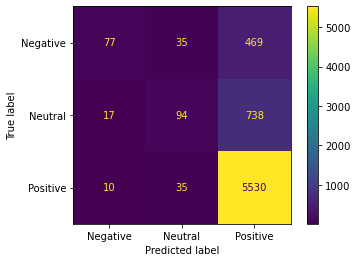

In [35]:
actual,predicted,vect=funct(ovr,input_train,input_test,label_train,label_test)

In [226]:
accuracy=[]
recall=[]
precision=[]
f1score=[]
model_name=[]

In [227]:
accuracy.append(accuracy_score(actual,predicted))
recall.append(recall_score(actual,predicted,average='weighted'))
precision.append(precision_score(actual,predicted,average='weighted'))
f1score.append(f1_score(actual,predicted,average='weighted'))
model_name.append('LogisTic regression with ovr(TD-IDF VECT)')

In [228]:
accuracy

[0.8138472519628837]

In [215]:
model_score.append([accuracy_score(actual,predicted), recall_score(actual,predicted, average='weighted'),f1_score(actual, predicted,average='weighted'),precision_score(actual,predicted, average='weighted')])
model_name.append('LogisTic regression with ovr(TD-IDF VECT)')

In [219]:
np.array(model_score)

array([[0.81384725, 0.81384725, 0.75606912, 0.78414978]])

In [ ]:
pd.DataFrame()

In [36]:
mylist=['It was a ok product','Product did  meet the expectations',"Product not worked"]

In [37]:
mylist_1=[]
for i in range(len(mylist)):
    c=vect.transform([mylist[i]])
    y_pred=ovr.predict(c)
    mylist_1.append(y_pred)

In [38]:
mylist_1

[array(['Neutral'], dtype='<U8'),
 array(['Positive'], dtype='<U8'),
 array(['Positive'], dtype='<U8')]

In [39]:
len(predicted)

7005

In [40]:
actual.index=range(len(predicted))

In [41]:
df_logreg_predicted=pd.DataFrame({"actual":pd.Series(actual),"predicted":pd.Series(predicted)})
df_logreg_predicted

,actual,predicted
0,Positive,Positive
1,Positive,Positive
2,Positive,Positive
3,Positive,Positive
4,Positive,Positive
...,...,...
7000,Positive,Positive
7001,Neutral,Positive
7002,Positive,Positive
7003,Positive,Positive


### (ii) Count Vectorizer with n grams

In [184]:
def funct_ngrams(classifier,input_train,input_test,label_train,label_test):
    vectorizer=CountVectorizer(ngram_range=(1,2))
    X_train=vectorizer.fit_transform(input_train)
    X_test=vectorizer.transform(input_test)
    clf=classifier.fit(X_train,label_train)
    y_pred=clf.predict(X_test)
    plot_confusion_matrix(clf,X_test,label_test)
    print(classification_report(label_test,y_pred))
    print('accuracy:', accuracy_score(label_test, y_pred))
    print('recall:', recall_score(label_test, y_pred, average='weighted'))
    print('f1-score:', f1_score(label_test, y_pred,average='weighted'))
    print('precision:', precision_score(label_test, y_pred, average='weighted'))
    return label_test,y_pred,vectorizer

In [185]:
lr_n = LogisticRegression(max_iter=200, verbose=1)
ovr_n = OneVsRestClassifier(lr_n)

### Confusion_Matrix and Classification_report

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    8.7s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   10.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   11.5s finished


              precision    recall  f1-score   support

    Negative       0.62      0.32      0.42       581
     Neutral       0.47      0.26      0.34       849
    Positive       0.86      0.96      0.91      5575

    accuracy                           0.82      7005
   macro avg       0.65      0.51      0.56      7005
weighted avg       0.79      0.82      0.80      7005

accuracy: 0.8229835831548894
recall: 0.8229835831548894
f1-score: 0.7979658860016051
precision: 0.7925740657741395


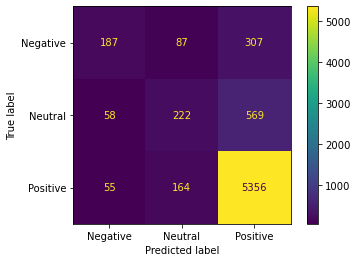

In [186]:
actual_n,predicted_n,vect_n=funct_ngrams(ovr_n,input_train,input_test,label_train,label_test)

In [229]:
accuracy.append(accuracy_score(actual_n,predicted_n))
recall.append(recall_score(actual_n,predicted_n,average='weighted'))
precision.append(precision_score(actual_n,predicted_n,average='weighted'))
f1score.append(f1_score(actual_n,predicted_n,average='weighted'))
model_name.append('LogisTic regression with ovr(Count Vectorizer with n grams 1,2 )')

### (iii) Multinomial Naive_Bayes

In [42]:
from sklearn.naive_bayes import MultinomialNB

In [43]:
model_nb=MultinomialNB()

### Confusion_Matrix and Classification_Report

C:\Users\Asus\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


              precision    recall  f1-score   support

    Negative       1.00      0.01      0.01       581
     Neutral       0.50      0.00      0.00       849
    Positive       0.80      1.00      0.89      5575

    accuracy                           0.80      7005
   macro avg       0.77      0.34      0.30      7005
weighted avg       0.78      0.80      0.71      7005

accuracy: 0.7967166309778729
recall: 0.7967166309778729
f1-score: 0.7075441373036195
precision: 0.7776578154173752


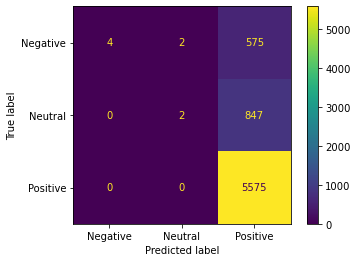

In [44]:
actual_nb,predicted_nb,vect_nb=funct(model_nb,input_train,input_test,label_train,label_test)

In [45]:
mylist_2=[]
for i in range(len(mylist)):
    c=vect_nb.transform([mylist[i]])
    y_pred=model_nb.predict(c)
    mylist_2.append(y_pred)

In [46]:
mylist_2

[array(['Positive'], dtype='<U8'),
 array(['Positive'], dtype='<U8'),
 array(['Positive'], dtype='<U8')]

In [47]:
actual_nb.index=range(len(predicted_nb))

In [48]:
df_nb_predicted=pd.DataFrame({"actual":pd.Series(actual_nb),"predicted":pd.Series(predicted_nb)})
df_nb_predicted

,actual,predicted
0,Positive,Positive
1,Positive,Positive
2,Positive,Positive
3,Positive,Positive
4,Positive,Positive
...,...,...
7000,Positive,Positive
7001,Neutral,Positive
7002,Positive,Positive
7003,Positive,Positive


In [231]:
accuracy.append(accuracy_score(actual_nb,predicted_nb))
recall.append(recall_score(actual_nb,predicted_nb,average='weighted'))
precision.append(precision_score(actual_nb,predicted_nb,average='weighted'))
f1score.append(f1_score(actual_nb,predicted_nb,average='weighted'))
model_name.append('Multinomial Naviye Bayes(TF-IDF)')

### (iv) Decision Tree Classifier

In [188]:
params = {'max_depth': [2,3,5,10,20],
    'max_leaf_nodes': [5,6,7,8,9,10]}

In [189]:
classif_dec=DecisionTreeClassifier()

In [190]:
from sklearn.model_selection import GridSearchCV

#### We are using GridsearchCV for the best parameters

In [191]:
grid_1 = GridSearchCV(estimator=classif_dec, param_grid=params,cv = 5,n_jobs=-1, scoring="accuracy")

              precision    recall  f1-score   support

    Negative       0.00      0.00      0.00       581
     Neutral       0.55      0.08      0.15       849
    Positive       0.80      0.99      0.89      5575

    accuracy                           0.80      7005
   macro avg       0.45      0.36      0.34      7005
weighted avg       0.71      0.80      0.72      7005

accuracy: 0.7995717344753748
recall: 0.7995717344753748
f1-score: 0.7245844833175319
precision: 0.7063543023714329


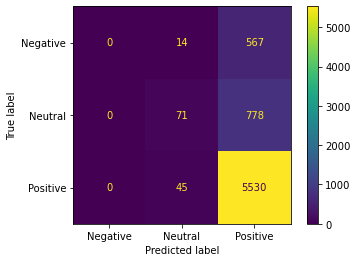

In [195]:
actual_d,predicted_d,vect_d=funct(grid_1,input_train,input_test,label_train,label_test)

In [232]:
accuracy.append(accuracy_score(actual_d,predicted_d))
recall.append(recall_score(actual_d,predicted_d,average='weighted'))
precision.append(precision_score(actual_d,predicted_d,average='weighted'))
f1score.append(f1_score(actual_d,predicted_d,average='weighted'))
model_name.append('Decision tree classifier')

### (v) RandomForest Classifier

In [198]:
vectorizer=TfidfVectorizer(sublinear_tf=True,max_df=0.5,min_df=1,stop_words=stopwords.words('english'),use_idf=True,smooth_idf=True)
X_r=vectorizer.fit_transform(X_f)

In [199]:
result_1=[]
model_name_1=[]

In [201]:
from sklearn.model_selection import RepeatedStratifiedKFold,cross_val_score

In [203]:
from sklearn.metrics import f1_score
from sklearn.ensemble import RandomForestClassifier

In [205]:
model_rand_1 = RandomForestClassifier()
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=42)
rep_scores= cross_val_score(model_rand_1, X_r, y_f, scoring='accuracy', cv=cv, n_jobs=-1, error_score='raise')
print(f"f1 micro scores are {rep_scores.mean()}")
result_1.append(rep_scores)
model_name_1.append('random forest classif using rep strat')

f1 micro scores are 0.8064870972930951


### Comparing the evaluation performance of our models by dataframe and graph

In [ ]:
df_comparision=pd.DataFrame({"model name":model_name,"accuracy":accuracy,"recall":recall,"precision":precision,"f1-score":f1score})
df_comparision

In [ ]:
df_comparision.plot.barh(x='model name',y='f1-score',color='g',rot=0,title='f1 score as per models')

### (vi)  Clasification Using Polarity

In [49]:
from textblob import TextBlob
df_final['polarity']=df_final['final_review'].apply( lambda x : TextBlob(x).sentiment.polarity)
df_final['polarity']

0        0.483333
1        0.483333
2       -0.083333
3       -0.083333
4        0.346250
           ...   
23344    0.243673
23345    0.174956
23346   -0.042727
23347    0.343265
23348    0.218182
Name: polarity, Length: 23349, dtype: float64

In [50]:
df_final.loc[(df_final["polarity"] > 0) , 'blobsentiment'] = 'Positive'
df_final.loc[(df_final["polarity"] == 0) , 'blobsentiment'] = 'Neutral'
df_final.loc[(df_final["polarity"] < 0) , 'blobsentiment'] = 'Negative'


In [51]:
df_final['blobsentiment']

0        Positive
1        Positive
2        Negative
3        Negative
4        Positive
           ...   
23344    Positive
23345    Positive
23346    Negative
23347    Positive
23348    Positive
Name: blobsentiment, Length: 23349, dtype: object

In [52]:
df_final.head()

,reviewTime,reviewerID,product_id,reviewText,summary,rating,main_cat,title,rank_no,price,reviewerName,verified,year,month,final_review,sentiment,polarity,blobsentiment
0,2018-01-05,A2HOI48JK8838M,B00004U9V2,This handcream has a beautiful fragrance. It d...,Beautiful Fragrance,5.0,Luxury Beauty,Crabtree &amp; Evelyn - Gardener's Ultra-Moist...,4324.0,30.0,DB,True,2018,1,handcream beautiful fragrance not stay protect...,Positive,0.483333,Positive
1,2018-01-05,A2HOI48JK8838M,B00004U9V2,This handcream has a beautiful fragrance. It d...,Beautiful Fragrance,3.0,Luxury Beauty,Crabtree &amp; Evelyn - Gardener's Ultra-Moist...,4324.0,30.0,DB,True,2018,1,handcream beautiful fragrance not stay protect...,Neutral,0.483333,Positive
2,2016-08-14,A2HOI48JK8838M,B00004U9V2,There is no evidence to me that this product i...,Paying for the name,5.0,Luxury Beauty,Crabtree &amp; Evelyn - Gardener's Ultra-Moist...,4324.0,30.0,DB,True,2016,8,no evidence product improvement similarly pric...,Positive,-0.083333,Negative
3,2016-08-14,A2HOI48JK8838M,B00004U9V2,There is no evidence to me that this product i...,Paying for the name,3.0,Luxury Beauty,Crabtree &amp; Evelyn - Gardener's Ultra-Moist...,4324.0,30.0,DB,True,2016,8,no evidence product improvement similarly pric...,Neutral,-0.083333,Negative
4,2017-04-05,A1YIPEY7HX73S7,B00004U9V2,"wonderful hand lotion, for seriously dry skin,...",wonderful hand lotion,5.0,Luxury Beauty,Crabtree &amp; Evelyn - Gardener's Ultra-Moist...,4324.0,30.0,Ajaey,True,2017,4,wonderful hand lotion seriously dry skin stay ...,Positive,0.346250,Positive


In [53]:
model_sb=MultinomialNB()

In [54]:
y_i=df_final['blobsentiment']

In [55]:
input_train_1,input_test_1,label_train_1,label_test_1=train_test_split(X_f, y_i, test_size=0.30, random_state=42)

C:\Users\Asus\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)
C:\Users\Asus\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Asus\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result

              precision    recall  f1-score   support

    Negative       0.00      0.00      0.00       565
     Neutral       0.00      0.00      0.00       230
    Positive       0.89      1.00      0.94      6210

    accuracy                           0.89      7005
   macro avg       0.30      0.33      0.31      7005
weighted avg       0.79      0.89      0.83      7005

accuracy: 0.8865096359743041
recall: 0.8865096359743041
f1-score: 0.8331781822777795
precision: 0.7858993346752932


C:\Users\Asus\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


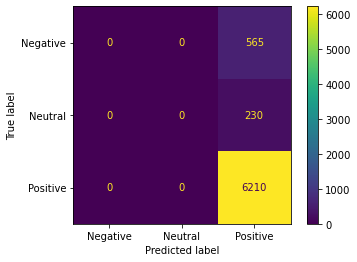

In [56]:
actual_sb,predicted_sb,vect_sb=funct(model_sb,input_train_1,input_test_1,label_train_1,label_test_1)

In [57]:
mylist_3=[]
for i in range(len(mylist)):
    c=vect_sb.transform([mylist[i]])
    y_pred=model_sb.predict(c)
    mylist_3.append(y_pred)

In [58]:
mylist_3

[array(['Positive'], dtype='<U8'),
 array(['Positive'], dtype='<U8'),
 array(['Positive'], dtype='<U8')]

### Text Augmantation(For Balancing) :

In [ ]:
df_final_w.head(2)

In [ ]:
df_final_w.reset_index(inplace=True)
dataset = df_final_w[['final_review', 'rating']]
dataset.head(2)

#### Checking the shape

In [ ]:
dataset.shape

In [ ]:
#reclassify
dataset['rating'] = dataset['rating'].apply(lambda x : 1 if x in (4,5) else -1 if x in (1,2) else 0)
#look at the destribution of data on our target variable
dataset['rating'].describe()
dataset['rating'].value_counts()/len(dataset)

#### Splittig the data into train|test

In [ ]:
from sklearn.model_selection import StratifiedShuffleSplit
split= StratifiedShuffleSplit(n_splits = 1, test_size = 0.2, random_state = 42) 
for train_index, test_index in split.split(dataset, dataset['rating']):
    strat_train_set = dataset.iloc[train_index]
    strat_test_set = dataset.iloc[test_index]

In [ ]:
strat_test_set['rating'].value_counts()/len(strat_test_set)

In [ ]:
strat_train_set['rating'].value_counts()/len(strat_train_set)

In [ ]:
#import necessary nltk libraries
import nltk
nltk.download('punkt')
nltk.download('wordnet')
from textaugment import Wordnet, Translate

In [ ]:
t=Wordnet()
#test
sentence ='Hello, I have been so exhausted lately. I need to rest'
t.augment(sentence)

In [ ]:
#augment reviews with scores less than 4
augmented = pd.DataFrame()
for i in strat_train_set[strat_train_set['rating'] != 1].index:
    text_aug = t.augment(str(strat_train_set['final_review'][i]))
    augmented = augmented.append({'final_review':text_aug ,'rating': dataset['rating'][i]} , ignore_index=True)

In [ ]:
#drop 60% of records with scores equal to 1 and add augmented to train set

part_na = round(strat_train_set[strat_train_set['rating'] == 1].shape[0]*0.6)
strat_train_set.head()
five_indices = strat_train_set[strat_train_set.rating == 1].index
random_indices = np.random.choice(five_indices, part_na, replace= False)
random_indices 

In [ ]:
strat_train_set.drop(random_indices, inplace = True)
strat_train_set['rating'].value_counts()/len(strat_train_set)

In [ ]:
#append augmented to strat_train_set
strat_train_set = strat_train_set.append(augmented)
strat_train_set['rating'].value_counts()/len(strat_train_set)

In [ ]:
strat_test_set['rating'].value_counts()/len(strat_test_set)

#### Model Building and Evaluation

In [ ]:
lr_t= LogisticRegression(max_iter=200, verbose=1)
ovr_t = OneVsRestClassifier(lr_t)

In [ ]:
actual_t,predicted_t,vect_t=funct(ovr_t,strat_train_set['final_review'],strat_test_set['final_review'],strat_train_set['rating'],strat_test_set['rating'])

###### We used text augumentation for reducing bias but as we can see that Accuracy is low as compared to our previous model we are not considering it.

## Clustering :

### Product Segmentation

#### We are grouping the product_id as per the mean of their rating,price and polarity

In [60]:
df_group=df_final.groupby('product_id').mean()[['rating','price','polarity']]
df_group.head()

,rating,price,polarity
product_id,,,
B00004U9V2,4.642857,30.0,0.442502
B00005V50B,4.428571,23.0,0.215060
B000068DWY,4.531250,64.0,0.319119
B000142FVW,4.517857,8.4,0.397212
B00014351Q,4.580000,8.4,0.426311


In [61]:
df_group.reset_index(inplace=True)

In [62]:
df_group.head()

,product_id,rating,price,polarity
0,B00004U9V2,4.642857,30.0,0.442502
1,B00005V50B,4.428571,23.0,0.215060
2,B000068DWY,4.531250,64.0,0.319119
3,B000142FVW,4.517857,8.4,0.397212
4,B00014351Q,4.580000,8.4,0.426311


### Merging the grouped one with our main dataset

In [63]:
df_clust=pd.merge(df_final,df_group,on='product_id',how='inner')
df_clust.head()

,reviewTime,reviewerID,product_id,reviewText,summary,rating_x,main_cat,title,rank_no,price_x,...,verified,year,month,final_review,sentiment,polarity_x,blobsentiment,rating_y,price_y,polarity_y
0,2018-01-05,A2HOI48JK8838M,B00004U9V2,This handcream has a beautiful fragrance. It d...,Beautiful Fragrance,5.0,Luxury Beauty,Crabtree &amp; Evelyn - Gardener's Ultra-Moist...,4324.0,30.0,...,True,2018,1,handcream beautiful fragrance not stay protect...,Positive,0.483333,Positive,4.642857,30.0,0.442502
1,2018-01-05,A2HOI48JK8838M,B00004U9V2,This handcream has a beautiful fragrance. It d...,Beautiful Fragrance,3.0,Luxury Beauty,Crabtree &amp; Evelyn - Gardener's Ultra-Moist...,4324.0,30.0,...,True,2018,1,handcream beautiful fragrance not stay protect...,Neutral,0.483333,Positive,4.642857,30.0,0.442502
2,2016-08-14,A2HOI48JK8838M,B00004U9V2,There is no evidence to me that this product i...,Paying for the name,5.0,Luxury Beauty,Crabtree &amp; Evelyn - Gardener's Ultra-Moist...,4324.0,30.0,...,True,2016,8,no evidence product improvement similarly pric...,Positive,-0.083333,Negative,4.642857,30.0,0.442502
3,2016-08-14,A2HOI48JK8838M,B00004U9V2,There is no evidence to me that this product i...,Paying for the name,3.0,Luxury Beauty,Crabtree &amp; Evelyn - Gardener's Ultra-Moist...,4324.0,30.0,...,True,2016,8,no evidence product improvement similarly pric...,Neutral,-0.083333,Negative,4.642857,30.0,0.442502
4,2017-04-05,A1YIPEY7HX73S7,B00004U9V2,"wonderful hand lotion, for seriously dry skin,...",wonderful hand lotion,5.0,Luxury Beauty,Crabtree &amp; Evelyn - Gardener's Ultra-Moist...,4324.0,30.0,...,True,2017,4,wonderful hand lotion seriously dry skin stay ...,Positive,0.346250,Positive,4.642857,30.0,0.442502


### Checking the shape

In [ ]:
df_clust.shape

In [65]:
df_clust_sel=df_clust[['rating_y','polarity_y']]
df_clust_sel.shape

(23349, 2)

#### During the merging process we got rating_x,rating_y as well ass polarity_x,polarity_y

In [66]:
df_clust_sel.head()

,rating_y,polarity_y
0,4.642857,0.442502
1,4.642857,0.442502
2,4.642857,0.442502
3,4.642857,0.442502
4,4.642857,0.442502


### Scaling the Data

In [68]:
scaler=StandardScaler()

In [69]:
df_scaled = scaler.fit_transform(df_clust_sel)
df_scaled

array([[ 1.10761312,  1.96533126],
       [ 1.10761312,  1.96533126],
       [ 1.10761312,  1.96533126],
       ...,
       [-1.27854051, -0.86542686],
       [-1.27854051, -0.86542686],
       [-1.27854051, -0.86542686]])

In [70]:
df_scaled_dataframe=pd.DataFrame(df_scaled,columns=['rating', 'polarity'])
df_scaled_dataframe.head()

,rating,polarity
0,1.107613,1.965331
1,1.107613,1.965331
2,1.107613,1.965331
3,1.107613,1.965331
4,1.107613,1.965331


### (i) K-means clustering

In [71]:
from sklearn.cluster import KMeans

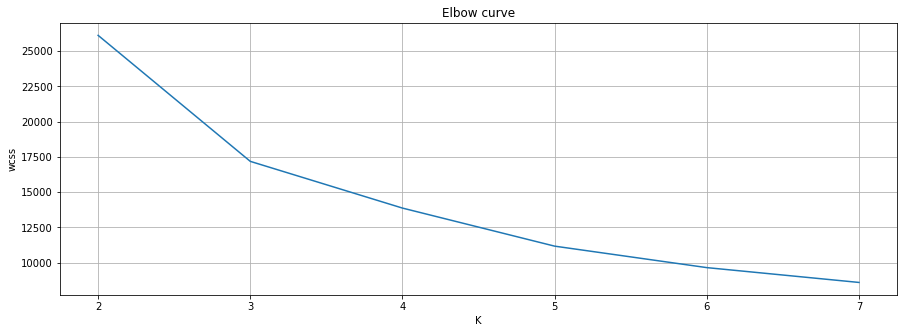

In [72]:
wcss = []
for k in range(2, 8):
    kmeans = KMeans(n_clusters=k)
    kmeans.fit(df_scaled)
    wcss.append(kmeans.inertia_)

fig = plt.figure(figsize=(15, 5))
plt.plot(range(2, 8), wcss)
plt.grid(True)
plt.xlabel('K')
plt.ylabel('wcss')
plt.title('Elbow curve');

#### From the above elbow graph we got the number of clusters as 3

In [73]:
k_model=KMeans(n_clusters=3)
y_pred_model=k_model.fit_predict(df_scaled)

In [74]:
from sklearn.metrics import silhouette_score

In [255]:
clust_name=[]
sil_score=[]

In [256]:
silhouette_score(df_scaled,y_pred_model)

0.404981764996347

In [257]:
clust_name.append('K-means')
sil_score.append(silhouette_score(df_scaled,y_pred_model))

In [258]:
clust_name

['K-means']

In [76]:
df_scaled_dataframe['cluster_label']=y_pred_model

In [77]:
df_scaled_dataframe.head()

,rating,polarity,cluster_label
0,1.107613,1.965331,0
1,1.107613,1.965331,0
2,1.107613,1.965331,0
3,1.107613,1.965331,0
4,1.107613,1.965331,0


In [78]:
df_clust_sel['cluster_label']=y_pred_model

C:\Users\Asus\AppData\Local\Temp\ipykernel_25720\917102093.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clust_sel['cluster_label']=y_pred_model


In [79]:
df_clust_sel.head()

,rating_y,polarity_y,cluster_label
0,4.642857,0.442502,0
1,4.642857,0.442502,0
2,4.642857,0.442502,0
3,4.642857,0.442502,0
4,4.642857,0.442502,0


### Made three clusters as Best, Average and Good

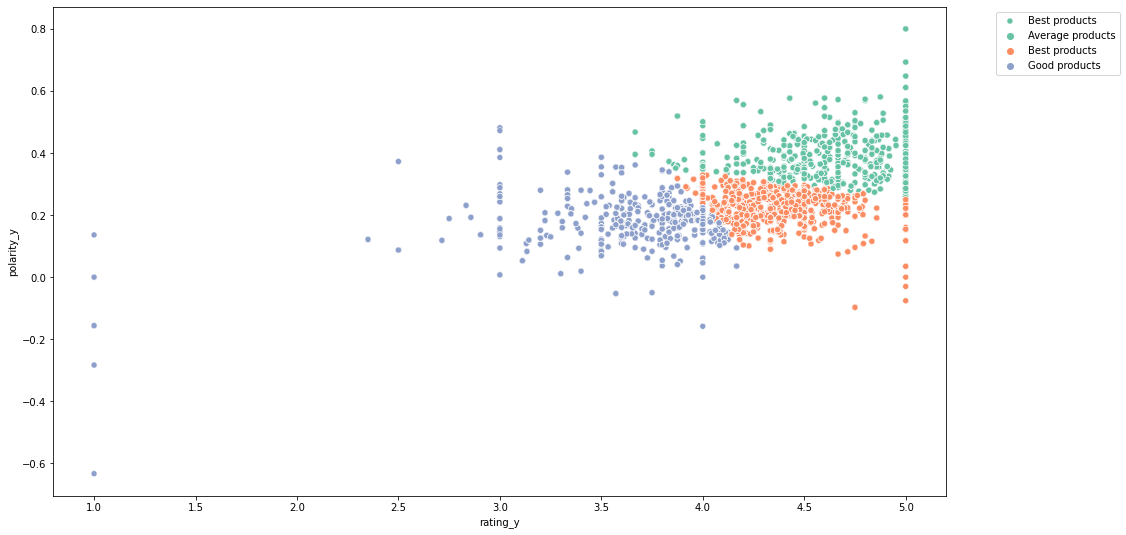

In [80]:
plt.figure(figsize=(16,9))
sns.scatterplot(data=df_clust_sel,x='rating_y',y='polarity_y',hue='cluster_label',palette='Set2')
plt.legend(bbox_to_anchor=[1.05,1],labels=['Best products','Average products','Best products','Good products']);

In [81]:
len(y_pred_model)

23349

In [82]:
df_clust['cluster_label']=y_pred_model


In [83]:
df_1=df_clust[['product_id','cluster_label']]
df_1.head()

,product_id,cluster_label
0,B00004U9V2,0
1,B00004U9V2,0
2,B00004U9V2,0
3,B00004U9V2,0
4,B00004U9V2,0


In [84]:
import numpy as np

### Giving the cluster lables to our dataset

In [85]:
df_1['labels']=df_1['cluster_label'].apply(lambda x:'Best products' if x==1 else 'Good products' if x ==2 else 'Average products')

C:\Users\Asus\AppData\Local\Temp\ipykernel_25720\2031786868.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_1['labels']=df_1['cluster_label'].apply(lambda x:'Best products' if x==1 else 'Good products' if x ==2 else 'Average products')


In [86]:
df_1

,product_id,cluster_label,labels
0,B00004U9V2,0,Average products
1,B00004U9V2,0,Average products
2,B00004U9V2,0,Average products
3,B00004U9V2,0,Average products
4,B00004U9V2,0,Average products
...,...,...,...
23344,B01DSY86YG,2,Good products
23345,B01DSY86YG,2,Good products
23346,B01DSY86YG,2,Good products
23347,B01DSY86YG,2,Good products


## (ii) Agglomerative

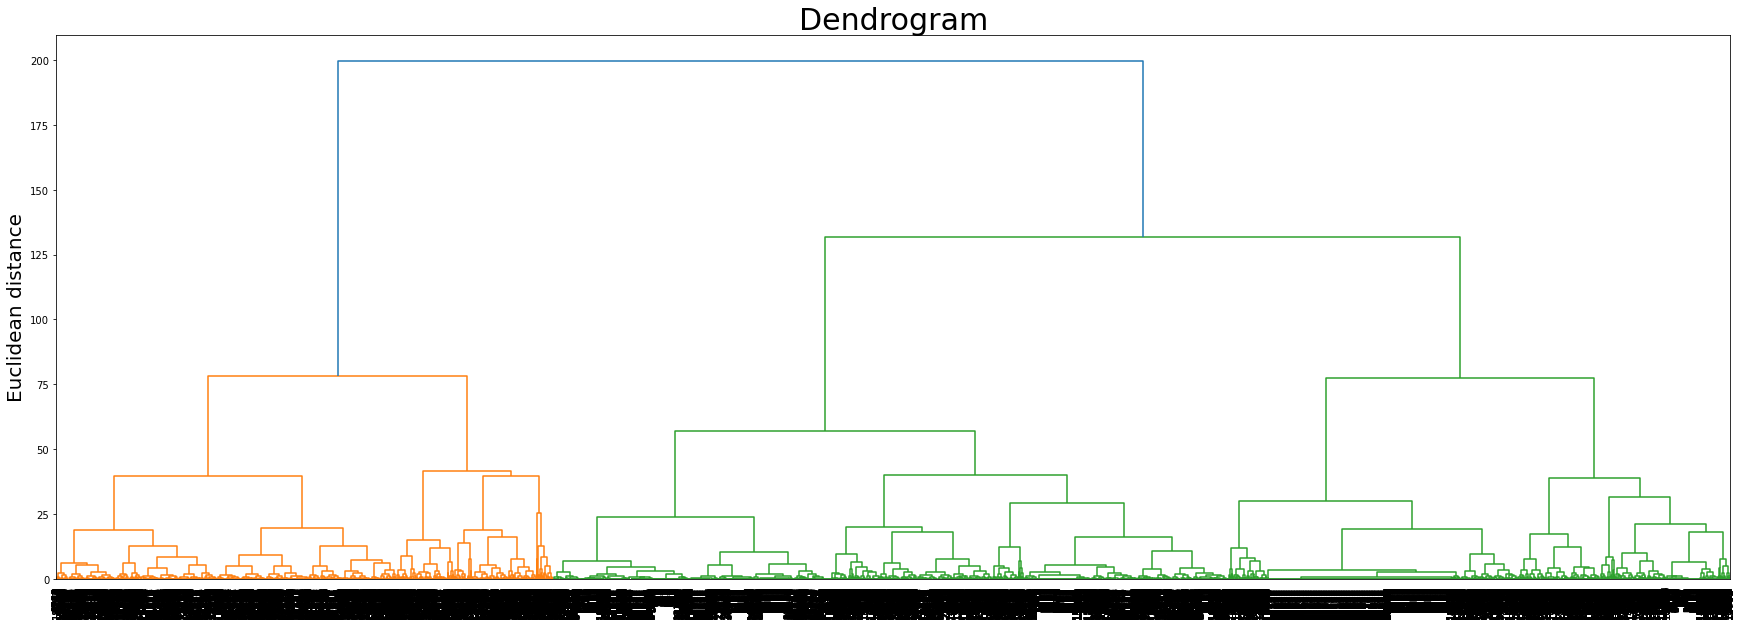

In [245]:
import scipy.cluster.hierarchy as sch
plt.figure(figsize=(30, 10))
dendrogrm = sch.dendrogram(sch.linkage(df_scaled, method = 'ward'),labels=df_scaled_dataframe.index)
#plt.axhline(y=12.5, color='r', linestyle='--')
ax = plt.gca()
ax.tick_params(axis='x', which='major', labelsize=10)
plt.title('Dendrogram',fontsize=30)

plt.ylabel('Euclidean distance', fontsize=20)
plt.show()

In [246]:
from sklearn.cluster import AgglomerativeClustering
hc = AgglomerativeClustering(n_clusters = 3, affinity = 'euclidean', linkage = 'ward')
y_hc = hc.fit_predict(df_scaled)

In [247]:
silhouette_score(df_scaled,y_hc)

0.3762784199074603

### Giving the cluster labels to our dataset

In [248]:
df_clust_sel['cluster_label_agglom']=y_hc

In [249]:
df_clust_sel.head()

,rating_y,polarity_y,cluster_label,cluster_label_agglom
0,4.642857,0.442502,0,1
1,4.642857,0.442502,0,1
2,4.642857,0.442502,0,1
3,4.642857,0.442502,0,1
4,4.642857,0.442502,0,1


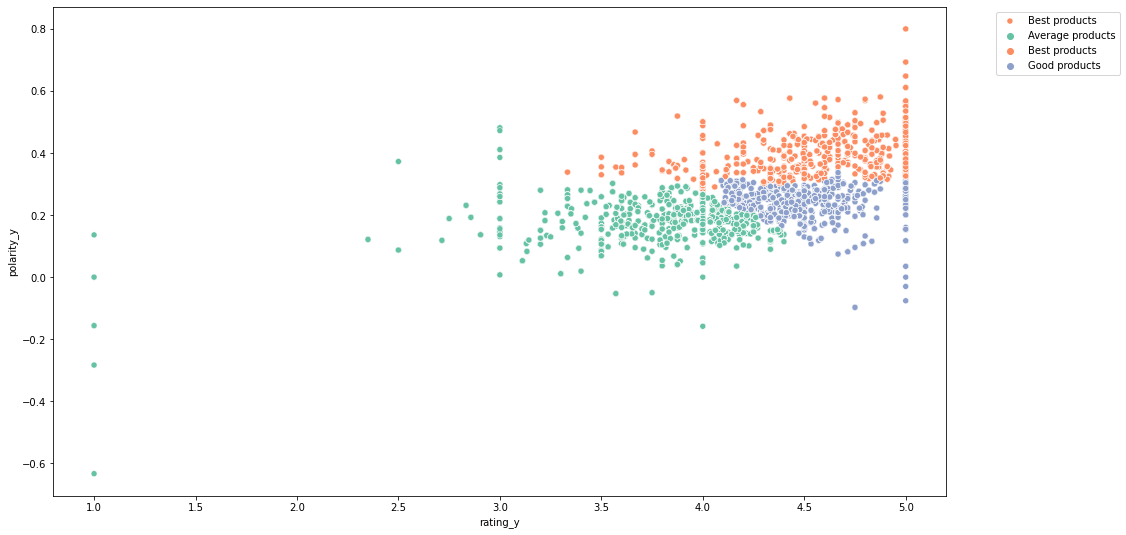

In [252]:
plt.figure(figsize=(16,9))
sns.scatterplot(data=df_clust_sel,x='rating_y',y='polarity_y',hue='cluster_label_agglom',palette='Set2')
plt.legend(bbox_to_anchor=[1.05,1],labels=['Best products','Average products','Best products','Good products']);

In [259]:
clust_name.append('Agglomerative clustering')
sil_score.append(silhouette_score(df_scaled,y_hc))

In [260]:
clust_name

['K-means', 'Agglomerative clustering']

### Comparision of kmeans with agglomerative

In [262]:
df_comp_clust=pd.DataFrame({"model":clust_name,"silhoutte_score":sil_score})
df_comp_clust

,model,silhoutte_score
0,K-means,0.404982
1,Agglomerative clustering,0.376278


#### Here we found that Kmeans is better

## Customer segmentation :


In [87]:
df_final.head()

,reviewTime,reviewerID,product_id,reviewText,summary,rating,main_cat,title,rank_no,price,reviewerName,verified,year,month,final_review,sentiment,polarity,blobsentiment
0,2018-01-05,A2HOI48JK8838M,B00004U9V2,This handcream has a beautiful fragrance. It d...,Beautiful Fragrance,5.0,Luxury Beauty,Crabtree &amp; Evelyn - Gardener's Ultra-Moist...,4324.0,30.0,DB,True,2018,1,handcream beautiful fragrance not stay protect...,Positive,0.483333,Positive
1,2018-01-05,A2HOI48JK8838M,B00004U9V2,This handcream has a beautiful fragrance. It d...,Beautiful Fragrance,3.0,Luxury Beauty,Crabtree &amp; Evelyn - Gardener's Ultra-Moist...,4324.0,30.0,DB,True,2018,1,handcream beautiful fragrance not stay protect...,Neutral,0.483333,Positive
2,2016-08-14,A2HOI48JK8838M,B00004U9V2,There is no evidence to me that this product i...,Paying for the name,5.0,Luxury Beauty,Crabtree &amp; Evelyn - Gardener's Ultra-Moist...,4324.0,30.0,DB,True,2016,8,no evidence product improvement similarly pric...,Positive,-0.083333,Negative
3,2016-08-14,A2HOI48JK8838M,B00004U9V2,There is no evidence to me that this product i...,Paying for the name,3.0,Luxury Beauty,Crabtree &amp; Evelyn - Gardener's Ultra-Moist...,4324.0,30.0,DB,True,2016,8,no evidence product improvement similarly pric...,Neutral,-0.083333,Negative
4,2017-04-05,A1YIPEY7HX73S7,B00004U9V2,"wonderful hand lotion, for seriously dry skin,...",wonderful hand lotion,5.0,Luxury Beauty,Crabtree &amp; Evelyn - Gardener's Ultra-Moist...,4324.0,30.0,Ajaey,True,2017,4,wonderful hand lotion seriously dry skin stay ...,Positive,0.346250,Positive


In [88]:
df_rev=df_final.groupby('reviewerID').mean()[['rating','polarity']]
df_rev.reset_index(inplace=True)

### Checking the shape

In [89]:
df_seg_merge=pd.merge(df_final,df_rev,on='reviewerID',how='inner')
df_seg_merge.shape

(23349, 20)

In [90]:
df_seg_merge.head()

,reviewTime,reviewerID,product_id,reviewText,summary,rating_x,main_cat,title,rank_no,price,reviewerName,verified,year,month,final_review,sentiment,polarity_x,blobsentiment,rating_y,polarity_y
0,2018-01-05,A2HOI48JK8838M,B00004U9V2,This handcream has a beautiful fragrance. It d...,Beautiful Fragrance,5.0,Luxury Beauty,Crabtree &amp; Evelyn - Gardener's Ultra-Moist...,4324.0,30.0,DB,True,2018,1,handcream beautiful fragrance not stay protect...,Positive,0.483333,Positive,4.333333,0.294444
1,2018-01-05,A2HOI48JK8838M,B00004U9V2,This handcream has a beautiful fragrance. It d...,Beautiful Fragrance,3.0,Luxury Beauty,Crabtree &amp; Evelyn - Gardener's Ultra-Moist...,4324.0,30.0,DB,True,2018,1,handcream beautiful fragrance not stay protect...,Neutral,0.483333,Positive,4.333333,0.294444
2,2016-08-14,A2HOI48JK8838M,B00004U9V2,There is no evidence to me that this product i...,Paying for the name,5.0,Luxury Beauty,Crabtree &amp; Evelyn - Gardener's Ultra-Moist...,4324.0,30.0,DB,True,2016,8,no evidence product improvement similarly pric...,Positive,-0.083333,Negative,4.333333,0.294444
3,2016-08-14,A2HOI48JK8838M,B00004U9V2,There is no evidence to me that this product i...,Paying for the name,3.0,Luxury Beauty,Crabtree &amp; Evelyn - Gardener's Ultra-Moist...,4324.0,30.0,DB,True,2016,8,no evidence product improvement similarly pric...,Neutral,-0.083333,Negative,4.333333,0.294444
4,2017-03-30,A2HOI48JK8838M,B00396VE7U,I was gardening for three hours. No burn. Nice...,Great product.,5.0,Luxury Beauty,Revision Skincare Intellishade SPF 45 Original...,2445.0,75.0,DB,False,2017,3,garden hour no burn nice finished look product...,Positive,0.700000,Positive,4.333333,0.294444


In [91]:
df_clust_sel_a=df_seg_merge[['rating_y','polarity_y']]
df_clust_sel_a.shape

(23349, 2)

### Sacling the data

In [92]:
scaler_a=StandardScaler()

In [93]:
df_scaled_a = scaler.fit_transform(df_clust_sel_a)
df_scaled_a

array([[ 0.1236832 ,  0.18084262],
       [ 0.1236832 ,  0.18084262],
       [ 0.1236832 ,  0.18084262],
       ...,
       [ 1.13272548, -0.90621928],
       [ 1.13272548,  0.70040564],
       [-0.38083794,  1.04678099]])

In [94]:
df_scaled_dataframe_a=pd.DataFrame(df_scaled_a,columns=['rating', 'polarity'])
df_scaled_dataframe_a.head()

,rating,polarity
0,0.123683,0.180843
1,0.123683,0.180843
2,0.123683,0.180843
3,0.123683,0.180843
4,0.123683,0.180843


## (i) Kmeans

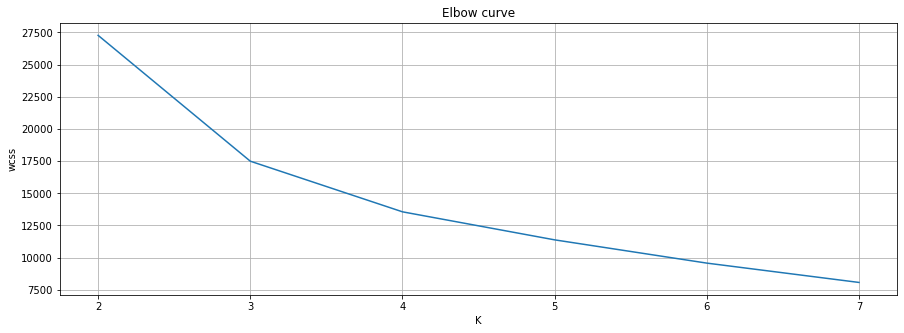

In [95]:
wcss = []
for k in range(2, 8):
    kmeans = KMeans(n_clusters=k)
    kmeans.fit(df_scaled_a)
    wcss.append(kmeans.inertia_)

fig = plt.figure(figsize=(15, 5))
plt.plot(range(2, 8), wcss)
plt.grid(True)
plt.xlabel('K')
plt.ylabel('wcss')
plt.title('Elbow curve');

#### From the elbow graph method we got no of clusters as 3

In [96]:
k_model_a=KMeans(n_clusters=3)
y_pred_model_a=k_model_a.fit_predict(df_scaled_a)

In [97]:
silhouette_score(df_scaled_a,y_pred_model_a)

0.41727327708195144

In [268]:
md_name=[]
si_score=[]

In [269]:
md_name.append('k-means')
si_score.append(silhouette_score(df_scaled_a,y_pred_model_a))

In [266]:
si_score

[0.41727327708195144]

In [270]:
md_name

['k-means']

In [98]:
df_clust_sel_a.head()

,rating_y,polarity_y
0,4.333333,0.294444
1,4.333333,0.294444
2,4.333333,0.294444
3,4.333333,0.294444
4,4.333333,0.294444


### Making the clusters 

In [99]:
df_clust_sel_a['cluster_label']=y_pred_model_a

C:\Users\Asus\AppData\Local\Temp\ipykernel_25720\3450533625.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clust_sel_a['cluster_label']=y_pred_model_a


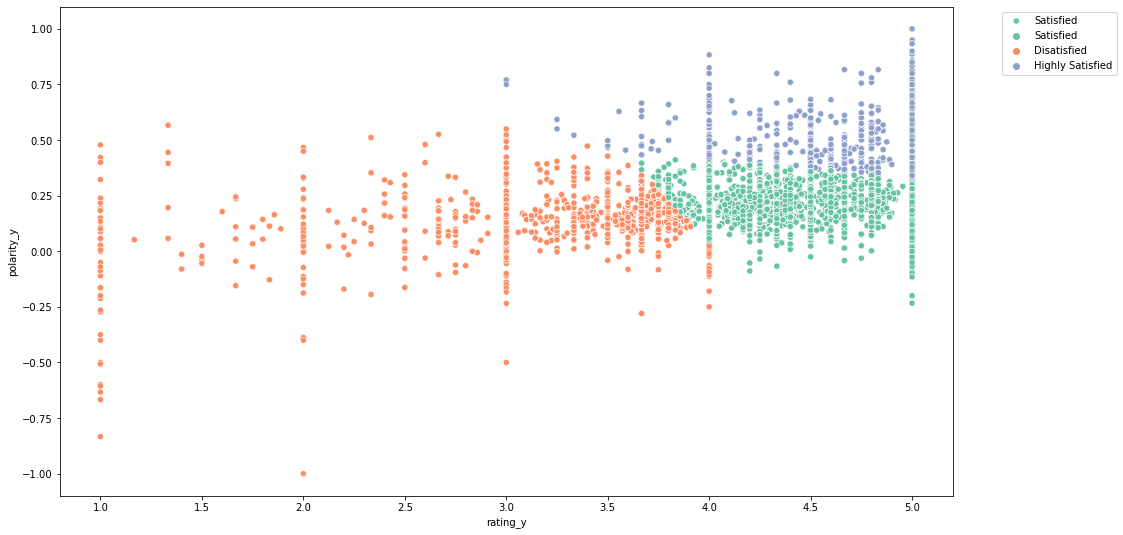

In [100]:
plt.figure(figsize=(16,9))
sns.scatterplot(data=df_clust_sel_a,x='rating_y',y='polarity_y',hue='cluster_label',palette='Set2')
plt.legend(bbox_to_anchor=[1.05,1],labels=['Satisfied','Satisfied','Disatisfied','Highly Satisfied']);

### Assigning the cluster label to our dataset

In [101]:
df_seg_merge['cluster_label']=y_pred_model_a

In [102]:
df_2=df_seg_merge[['reviewerID','cluster_label']]
df_2

,reviewerID,cluster_label
0,A2HOI48JK8838M,0
1,A2HOI48JK8838M,0
2,A2HOI48JK8838M,0
3,A2HOI48JK8838M,0
4,A2HOI48JK8838M,0
...,...,...
23344,A1YLRQL1XZBKCS,1
23345,A1S7TXHM2VM5EF,0
23346,A1S7TXHM2VM5EF,0
23347,A20W9PSUAKDRN1,2


In [103]:
df_2['labels']=df_2['cluster_label'].apply(lambda x:'Dissatisfied customers' if x==1 else 'Highly Satisfied customers' if x ==2 else 'Satisfied')

C:\Users\Asus\AppData\Local\Temp\ipykernel_25720\949955141.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_2['labels']=df_2['cluster_label'].apply(lambda x:'Dissatisfied customers' if x==1 else 'Highly Satisfied customers' if x ==2 else 'Satisfied')


In [104]:
df_2

,reviewerID,cluster_label,labels
0,A2HOI48JK8838M,0,Satisfied
1,A2HOI48JK8838M,0,Satisfied
2,A2HOI48JK8838M,0,Satisfied
3,A2HOI48JK8838M,0,Satisfied
4,A2HOI48JK8838M,0,Satisfied
...,...,...,...
23344,A1YLRQL1XZBKCS,1,Dissatisfied customers
23345,A1S7TXHM2VM5EF,0,Satisfied
23346,A1S7TXHM2VM5EF,0,Satisfied
23347,A20W9PSUAKDRN1,2,Highly Satisfied customers


## (ii) Agglomerative

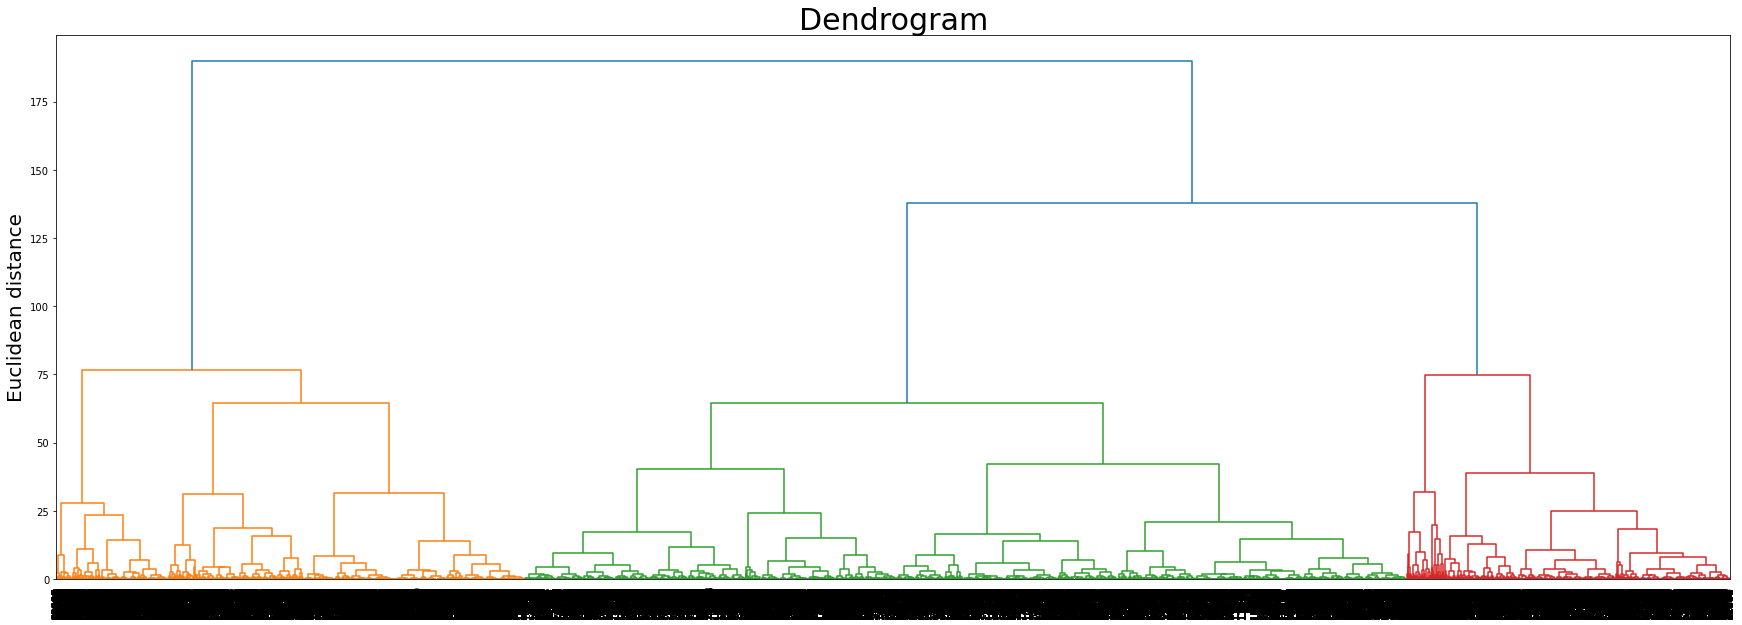

In [272]:
plt.figure(figsize=(30, 10))
dendrogrm = sch.dendrogram(sch.linkage(df_scaled_a, method = 'ward'),labels=df_scaled_dataframe_a.index)
#plt.axhline(y=12.5, color='r', linestyle='--')
ax = plt.gca()
ax.tick_params(axis='x', which='major', labelsize=10)
plt.title('Dendrogram',fontsize=30)

plt.ylabel('Euclidean distance', fontsize=20)
plt.show()

In [273]:
hc_a= AgglomerativeClustering(n_clusters = 3, affinity = 'euclidean', linkage = 'ward')
y_hc_a= hc.fit_predict(df_scaled_a)

In [274]:
md_name.append('agglomerative')
si_score.append(silhouette_score(df_scaled_a,y_hc_a))

In [275]:
md_name

['k-means', 'agglomerative']

In [276]:
si_score

[0.41727327708195144, 0.36784740654428777]

### Comparing the clustering models 

In [277]:
df_comp_clust_agg=pd.DataFrame({"model":md_name,"silhoutte_score":si_score})
df_comp_clust_agg

,model,silhoutte_score
0,k-means,0.417273
1,agglomerative,0.367847


#### Here we got that K means is better

# Time series Analysis And Sentiment Forecasting

In [105]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller,acf,pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
import warnings
warnings.filterwarnings('ignore')

## Reading the first 5 of our data

In [106]:
df_final.head()

,reviewTime,reviewerID,product_id,reviewText,summary,rating,main_cat,title,rank_no,price,reviewerName,verified,year,month,final_review,sentiment,polarity,blobsentiment
0,2018-01-05,A2HOI48JK8838M,B00004U9V2,This handcream has a beautiful fragrance. It d...,Beautiful Fragrance,5.0,Luxury Beauty,Crabtree &amp; Evelyn - Gardener's Ultra-Moist...,4324.0,30.0,DB,True,2018,1,handcream beautiful fragrance not stay protect...,Positive,0.483333,Positive
1,2018-01-05,A2HOI48JK8838M,B00004U9V2,This handcream has a beautiful fragrance. It d...,Beautiful Fragrance,3.0,Luxury Beauty,Crabtree &amp; Evelyn - Gardener's Ultra-Moist...,4324.0,30.0,DB,True,2018,1,handcream beautiful fragrance not stay protect...,Neutral,0.483333,Positive
2,2016-08-14,A2HOI48JK8838M,B00004U9V2,There is no evidence to me that this product i...,Paying for the name,5.0,Luxury Beauty,Crabtree &amp; Evelyn - Gardener's Ultra-Moist...,4324.0,30.0,DB,True,2016,8,no evidence product improvement similarly pric...,Positive,-0.083333,Negative
3,2016-08-14,A2HOI48JK8838M,B00004U9V2,There is no evidence to me that this product i...,Paying for the name,3.0,Luxury Beauty,Crabtree &amp; Evelyn - Gardener's Ultra-Moist...,4324.0,30.0,DB,True,2016,8,no evidence product improvement similarly pric...,Neutral,-0.083333,Negative
4,2017-04-05,A1YIPEY7HX73S7,B00004U9V2,"wonderful hand lotion, for seriously dry skin,...",wonderful hand lotion,5.0,Luxury Beauty,Crabtree &amp; Evelyn - Gardener's Ultra-Moist...,4324.0,30.0,Ajaey,True,2017,4,wonderful hand lotion seriously dry skin stay ...,Positive,0.346250,Positive


## Checking the columns of our dataframe

In [107]:
df_final.columns

Index(['reviewTime', 'reviewerID', 'product_id', 'reviewText', 'summary',
       'rating', 'main_cat', 'title', 'rank_no', 'price', 'reviewerName',
       'verified', 'year', 'month', 'final_review', 'sentiment', 'polarity',
       'blobsentiment'],
      dtype='object')

## Creating a copy of our dataframe

In [108]:
df_final_p=df_final.copy()

## Setting the reviewTime column as index

In [109]:
df_final.set_index('reviewTime',inplace=True)

In [110]:
df_final.head()

,reviewerID,product_id,reviewText,summary,rating,main_cat,title,rank_no,price,reviewerName,verified,year,month,final_review,sentiment,polarity,blobsentiment
reviewTime,,,,,,,,,,,,,,,,,
2018-01-05,A2HOI48JK8838M,B00004U9V2,This handcream has a beautiful fragrance. It d...,Beautiful Fragrance,5.0,Luxury Beauty,Crabtree &amp; Evelyn - Gardener's Ultra-Moist...,4324.0,30.0,DB,True,2018,1,handcream beautiful fragrance not stay protect...,Positive,0.483333,Positive
2018-01-05,A2HOI48JK8838M,B00004U9V2,This handcream has a beautiful fragrance. It d...,Beautiful Fragrance,3.0,Luxury Beauty,Crabtree &amp; Evelyn - Gardener's Ultra-Moist...,4324.0,30.0,DB,True,2018,1,handcream beautiful fragrance not stay protect...,Neutral,0.483333,Positive
2016-08-14,A2HOI48JK8838M,B00004U9V2,There is no evidence to me that this product i...,Paying for the name,5.0,Luxury Beauty,Crabtree &amp; Evelyn - Gardener's Ultra-Moist...,4324.0,30.0,DB,True,2016,8,no evidence product improvement similarly pric...,Positive,-0.083333,Negative
2016-08-14,A2HOI48JK8838M,B00004U9V2,There is no evidence to me that this product i...,Paying for the name,3.0,Luxury Beauty,Crabtree &amp; Evelyn - Gardener's Ultra-Moist...,4324.0,30.0,DB,True,2016,8,no evidence product improvement similarly pric...,Neutral,-0.083333,Negative
2017-04-05,A1YIPEY7HX73S7,B00004U9V2,"wonderful hand lotion, for seriously dry skin,...",wonderful hand lotion,5.0,Luxury Beauty,Crabtree &amp; Evelyn - Gardener's Ultra-Moist...,4324.0,30.0,Ajaey,True,2017,4,wonderful hand lotion seriously dry skin stay ...,Positive,0.346250,Positive


## Sorting the index as per their reviewTime

In [111]:
df_final.sort_index(inplace=True)

In [112]:
df_final.head()

,reviewerID,product_id,reviewText,summary,rating,main_cat,title,rank_no,price,reviewerName,verified,year,month,final_review,sentiment,polarity,blobsentiment
reviewTime,,,,,,,,,,,,,,,,,
2005-09-20,A3CJ7MHAS9IMAM,B000MIH34Q,I was in Nordstroms when they were having a Ja...,"Great product, Less than ideal packaging",4.0,Luxury Beauty,JACK BLACK - Intense Therapy Lip Balm SPF 25 -...,470.0,7.500,Dom Miliano,False,2005,9,nordstrom have jack black product promotion bu...,Positive,0.402500,Positive
2007-01-16,AIIR8E34EDKCQ,B000VOJPMY,I have always thought the decanter holding the...,Kingdom of true beauty,5.0,Luxury Beauty,Juicy Couture Women's Perfume,129675.0,76.000,Kasia S.,False,2007,1,think decanter hold precious liquid pretty unp...,Positive,0.239394,Positive
2007-01-21,A281NPSIMI1C2R,B0006O4M8Q,The Jack Black Industrial Strength Hand Healer...,Rice Bran Oil and Eucalyptus,5.0,Luxury Beauty,JACK BLACK &ndash; Industrial Strength Hand He...,2004.0,15.000,Rebecca of Amazon,False,2007,1,jack black industrial strength hand healer wor...,Positive,0.186943,Positive
2007-02-25,A2SH7OWE8QJYNC,B000Z5YFX8,I bought the 5-Day Detox kit so I could try a ...,"Cooling, but not as moisturizing as I'd like",3.0,Luxury Beauty,skyn Iceland The Antidote Cooling Daily Lotion,21180.0,45.000,Delamaine,False,2007,2,buy day detox kit try lot skyn iceland product...,Neutral,0.255519,Positive
2007-02-28,AK7CAW3N1XZV6,B0009STDD8,Calvin Klein's Obsession was one of the earlie...,The fragrance that started it all!,4.0,Luxury Beauty,Calvin Klein OBSESSION Eau de Parfum,13123.0,85.525,Reviewer Dr. Beth,False,2007,2,calvin klein s obsession early release designe...,Positive,0.141176,Positive


## Analysis of Positive Negative and Neutral sentiments

In [376]:
df_positive=df_final[df_final['blobsentiment']=='Positive']
df_negative=df_final[df_final['blobsentiment']=='Negative']
df_neutral=df_final[df_final['blobsentiment']=='Neutral']

In [377]:
df_positive.head(3)

,reviewerID,product_id,reviewText,summary,rating,main_cat,title,rank_no,price,reviewerName,verified,year,month,final_review,sentiment,polarity,blobsentiment
reviewTime,,,,,,,,,,,,,,,,,
2005-09-20,A3CJ7MHAS9IMAM,B000MIH34Q,I was in Nordstroms when they were having a Ja...,"Great product, Less than ideal packaging",4.0,Luxury Beauty,JACK BLACK - Intense Therapy Lip Balm SPF 25 -...,470.0,7.500,Dom Miliano,False,2005,9,nordstrom have jack black product promotion bu...,Positive,0.402500,Positive
2007-01-16,AIIR8E34EDKCQ,B000VOJPMY,I have always thought the decanter holding the...,Kingdom of true beauty,5.0,Luxury Beauty,Juicy Couture Women's Perfume,129675.0,76.000,Kasia S.,False,2007,1,think decanter hold precious liquid pretty unp...,Positive,0.239394,Positive
2007-01-21,A281NPSIMI1C2R,B0006O4M8Q,The Jack Black Industrial Strength Hand Healer...,Rice Bran Oil and Eucalyptus,5.0,Luxury Beauty,JACK BLACK &ndash; Industrial Strength Hand He...,2004.0,15.000,Rebecca of Amazon,False,2007,1,jack black industrial strength hand healer wor...,Positive,0.186943,Positive
2007-02-25,A2SH7OWE8QJYNC,B000Z5YFX8,I bought the 5-Day Detox kit so I could try a ...,"Cooling, but not as moisturizing as I'd like",3.0,Luxury Beauty,skyn Iceland The Antidote Cooling Daily Lotion,21180.0,45.000,Delamaine,False,2007,2,buy day detox kit try lot skyn iceland product...,Neutral,0.255519,Positive
2007-02-28,AK7CAW3N1XZV6,B0009STDD8,Calvin Klein's Obsession was one of the earlie...,The fragrance that started it all!,4.0,Luxury Beauty,Calvin Klein OBSESSION Eau de Parfum,13123.0,85.525,Reviewer Dr. Beth,False,2007,2,calvin klein s obsession early release designe...,Positive,0.141176,Positive


## Converting the datatype of reviewTime from object to DateTime

In [378]:
df_final.index=pd.to_datetime(df_final.index)

In [379]:
df_final.index

DatetimeIndex(['2005-09-20', '2007-01-16', '2007-01-21', '2007-02-25',
               '2007-02-28', '2007-03-05', '2007-04-25', '2007-08-01',
               '2007-08-16', '2007-11-17',
               ...
               '2018-09-09', '2018-09-09', '2018-09-12', '2018-09-13',
               '2018-09-13', '2018-09-16', '2018-09-16', '2018-09-23',
               '2018-09-23', '2018-09-24'],
              dtype='datetime64[ns]', name='reviewTime', length=23349, freq=None)

In [380]:
df_final.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 23349 entries, 2005-09-20 to 2018-09-24
Data columns (total 17 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   reviewerID     23349 non-null  object 
 1   product_id     23349 non-null  object 
 2   reviewText     23349 non-null  object 
 3   summary        23349 non-null  object 
 4   rating         23349 non-null  float64
 5   main_cat       23349 non-null  object 
 6   title          23349 non-null  object 
 7   rank_no        23349 non-null  float64
 8   price          23349 non-null  float64
 9   reviewerName   23349 non-null  object 
 10  verified       23349 non-null  bool   
 11  year           23349 non-null  int64  
 12  month          23349 non-null  int64  
 13  final_review   23349 non-null  object 
 14  sentiment      23349 non-null  object 
 15  polarity       23349 non-null  float64
 16  blobsentiment  23349 non-null  object 
dtypes: bool(1), float64(4), int64(2),

## Performing the resampling by Month

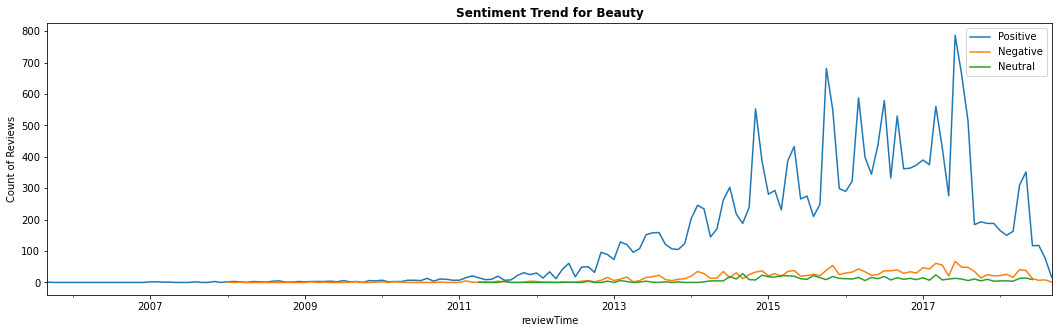

In [381]:
df_positive['product_id'].resample('M').count().plot(figsize=(18,5),label='Positive')
df_negative['product_id'].resample('M').count().plot(figsize=(18,5),label='Negative')
df_neutral['product_id'].resample('M').count().plot(figsize=(18,5),label='Neutral')
plt.legend()
plt.title('Sentiment Trend for Beauty',fontweight='bold')
plt.ylabel('Count of Reviews');
     

#### Here we can see that positive reviews rate is increasing as per the time

In [382]:
df_positive_re=df_positive['product_id'].resample('M').count()

In [383]:
df_negative_re=df_negative['product_id'].resample('M').count()

In [384]:
df_neutral_re=df_neutral['product_id'].resample('M').count()

## Using the decomposition for checking the trend,seasonality and residuals in our data

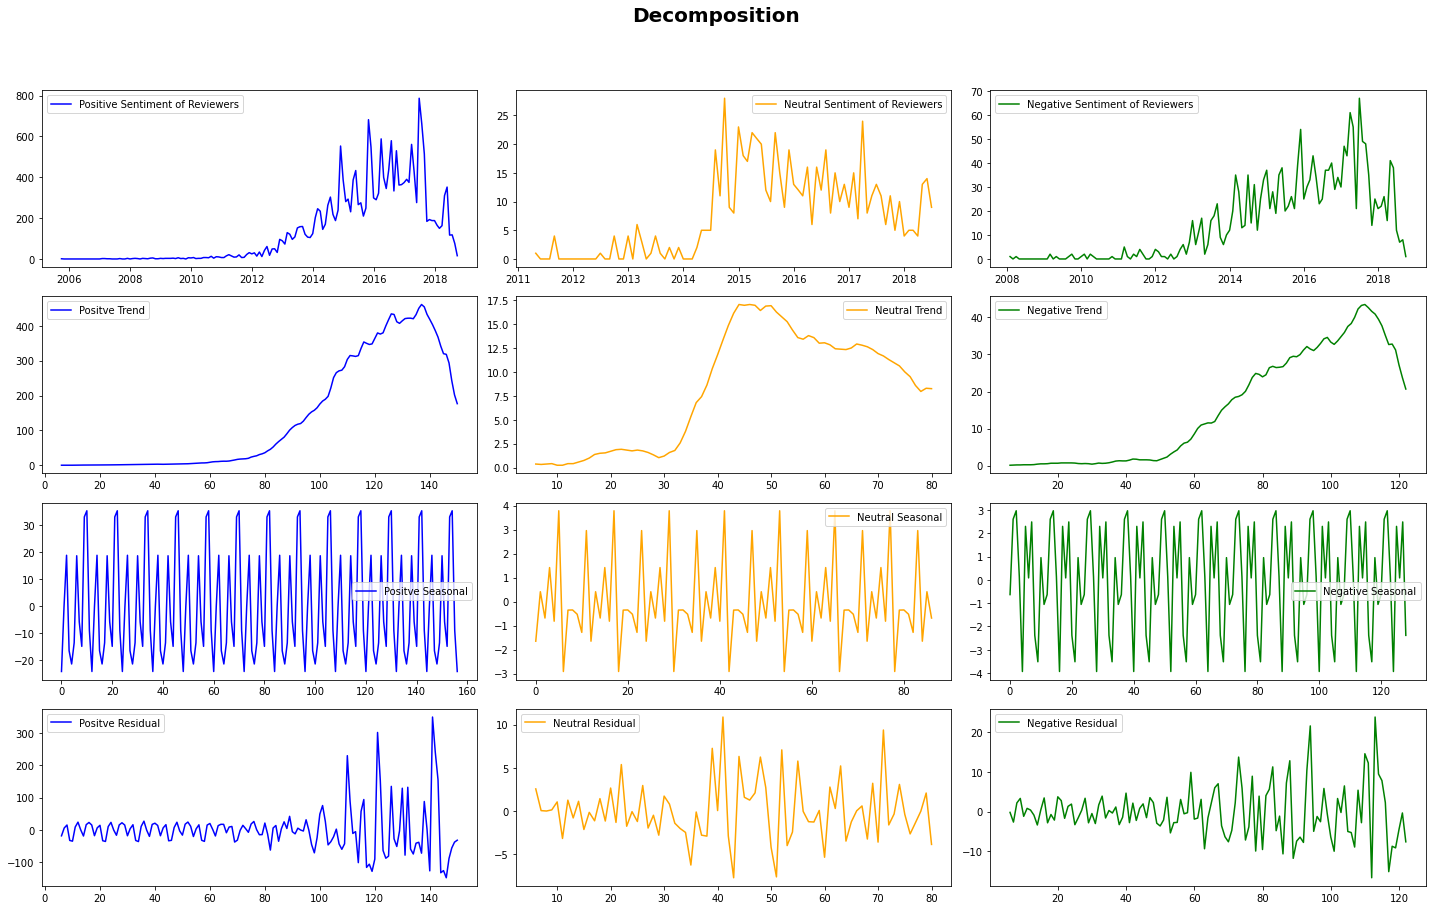

In [307]:
# Decomposition plot for predicted data using Features
decomposition_p=seasonal_decompose(np.asarray(df_positive_re), period=12)
d_trend_p=decomposition_p.trend
d_seasonal_p=decomposition_p.seasonal
d_residual_p=decomposition_p.resid
decomposition=seasonal_decompose(np.asarray(df_neutral_re), period=12)
d_trend=decomposition.trend
d_seasonal=decomposition.seasonal
d_residual=decomposition.resid
decomposition_n=seasonal_decompose(np.asarray(df_negative_re), period=12)
d_trend_n=decomposition_n.trend
d_seasonal_n=decomposition_n.seasonal
d_residual_n=decomposition_n.resid
# plotting all the 4 graphs
fig,ax = plt.subplots(4,3,figsize=(20,12))
plt.subplot(4,3,1)
plt.plot(df_positive_re,label='Positive Sentiment of Reviewers',color='b')
plt.legend(loc='best')
plt.subplot(4,3,2)
plt.plot(df_neutral_re,label='Neutral Sentiment of Reviewers',color='orange')
plt.legend(loc='best')
plt.subplot(4,3,3)
plt.plot(df_negative_re,label='Negative Sentiment of Reviewers',color='g')
plt.legend(loc='best')
plt.subplot(4,3,4)
plt.plot(d_trend_p,label='Positve Trend',color='b')
plt.legend(loc='best')
plt.subplot(4,3,5)
plt.plot(d_trend,label='Neutral Trend',color='orange')
plt.legend(loc='best')
plt.subplot(4,3,6)
plt.plot(d_trend_n,label='Negative Trend',color='g')
plt.legend(loc='best')
plt.subplot(4,3,7)
plt.plot(d_seasonal_p,label='Positve Seasonal',color='b')
plt.legend(loc='best')
plt.subplot(4,3,8)
plt.plot(d_seasonal,label='Neutral Seasonal',color='orange')
plt.legend(loc='best')
plt.subplot(4,3,9)
plt.plot(d_seasonal_n,label='Negative Seasonal',color='g')
plt.legend(loc='best')
plt.subplot(4,3,10)
plt.plot(d_residual_p,label='Positve Residual',color='b')
plt.legend(loc='best')
plt.subplot(4,3,11)
plt.plot(d_residual,label='Neutral Residual',color='orange')
plt.legend(loc='best')
plt.subplot(4,3,12)
plt.plot(d_residual_n,label='Negative Residual',color='g')
plt.legend(loc='best')
plt.suptitle('Decomposition',x=0.5,y=1.05,fontweight='bold',fontsize=20)
plt.tight_layout()
     


## Defining a function to check the stationarity of our data

In [308]:
# dickey-fuller test for stationarity
# dickey-fuller test for stationarity
def checkStationarity(data):
    pvalue = adfuller(data)[1]
    '''
    output:-> 
    1) test statistic, 
    2) p-value, 
    3) number of lags, 
    4) total observations
    
    dfoutput = pd.Series(result[0:4],index=['tstat','pvalue','lags','obs'])
    pvalue = dfoutput['pvalue']
    '''
    
    if(pvalue>0.05):
        msg = 'p-value={}. Data is not stationary'.format(pvalue)
    else:
        msg='p-value={}. Data is stationary'.format(pvalue)
        
    return(msg)

### Checking for the Positive 

In [385]:
print(checkStationarity(df_positive_re))

p-value=0.45522845677775864. Data is not stationary


In [386]:
df_pd=pd.DataFrame(df_positive_re)

In [311]:
from statsmodels.tsa.statespace.tools import diff

In [387]:
# difference the data by 2
df_pd['diff_1'] = diff(df_pd['product_id'],k_diff=2) #d = 2

In [388]:
# check if the difference data is stationary
checkStationarity(df_pd['diff_1'].dropna())

'p-value=4.256477636618703e-09. Data is stationary'

In [389]:
df_pd.head()

,product_id,diff_1
reviewTime,,
2005-09-30,1,NaN
2005-10-31,0,NaN
2005-11-30,0,1.0
2005-12-31,0,0.0
2006-01-31,0,0.0


### Checking for the Negative

In [390]:
print(checkStationarity(df_negative_re))

p-value=0.6135472914657507. Data is not stationary


In [391]:
df_nd=pd.DataFrame(df_negative_re)

In [392]:
# difference the data by 1
df_nd['diff_1'] = diff(df_nd['product_id'],k_diff=1) #d = 1

In [393]:
# check if the difference data is stationary
checkStationarity(df_nd['diff_1'].dropna())

'p-value=3.18918235213927e-16. Data is stationary'

### Checking for the Neutral

In [394]:
print(checkStationarity(df_neutral_re))

p-value=0.4413468080387119. Data is not stationary


In [395]:
df_ne=pd.DataFrame(df_neutral_re)

In [396]:
# difference the data by 1
df_ne['diff_1'] = diff(df_ne['product_id'],k_diff=1) #d = 1

In [397]:
# check if the difference data is stationary
checkStationarity(df_ne['diff_1'].dropna())

'p-value=1.7211906869126628e-13. Data is stationary'

## Finding the autocorrelation(q) and partial_autocorrelation(p) values for our models

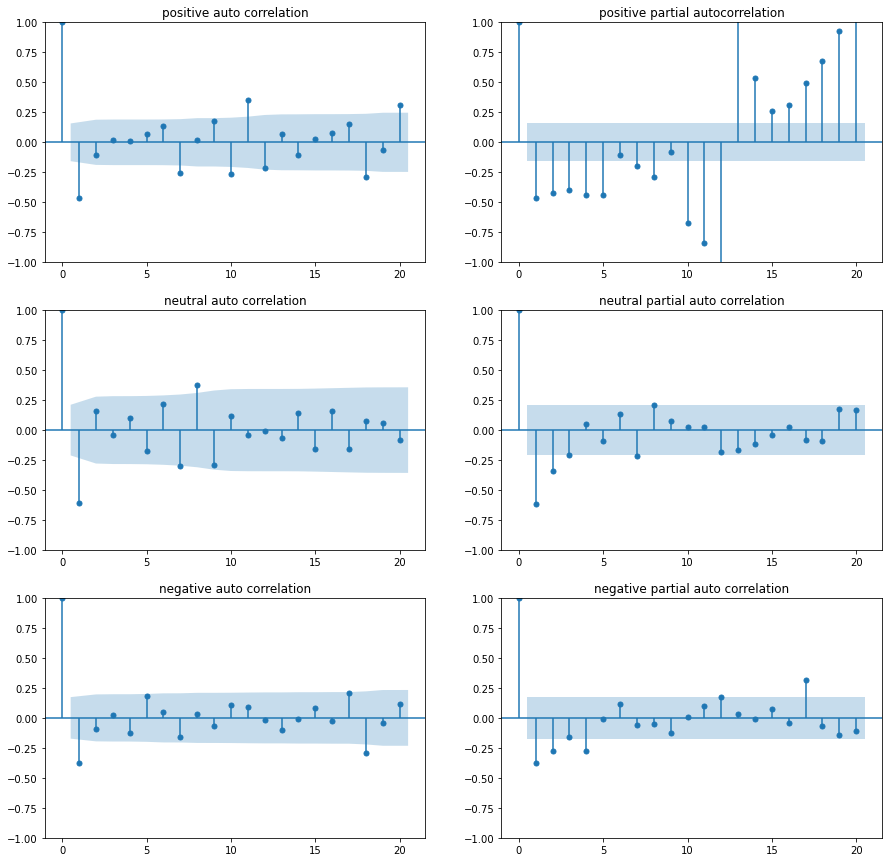

In [327]:
fig,ax=plt.subplots(3,2,figsize=(15,15))
plot_acf(df_pd['diff_1'].dropna(),lags=20,ax=ax[0,0])
plot_pacf(df_pd['diff_1'].dropna(),lags=20,ax=ax[0,1])
ax[0,0].set_title('positive auto correlation')
ax[0,1].set_title('positive partial autocorrelation')
plot_acf(df_ne['diff_1'].dropna(),lags=20,ax=ax[1,0])
plot_pacf(df_ne['diff_1'].dropna(),lags=20,ax=ax[1,1])
ax[1,0].set_title('neutral auto correlation')
ax[1,1].set_title('neutral partial auto correlation')
plot_acf(df_nd['diff_1'].dropna(),lags=20,ax=ax[2,0])
plot_pacf(df_nd['diff_1'].dropna(),lags=20,ax=ax[2,1])
ax[2,0].set_title('negative auto correlation')
ax[2,1].set_title('negative partial auto correlation')
plt.show()
     

for positive sentiments : q=1,p=5,d=2

for neutral sentiments : q=1,p=2,d=1

for negative sentiments : q=1,p=2,d=1

## Building the Models :

## ARIMA Model

### For Positive Sentiments

In [398]:
df_pd.drop('diff_1',axis=1,inplace=True)

In [399]:
ss = int(0.9 * len(df_pd))

train = df_pd.iloc[:ss]
test = df_pd.iloc[ss:]
print("train = {}, test = {}".format(len(train), len(test)))

train = 141, test = 16


In [400]:
train.head()

,product_id
reviewTime,
2005-09-30,1
2005-10-31,0
2005-11-30,0
2005-12-31,0
2006-01-31,0


In [331]:
def ljung_box(a):
    pvalue = sm.stats.acorr_ljungbox(a.resid,lags=[1],return_df=True)['lb_pvalue'].values
    if pvalue < 0.05:
        print("Reject H0. Bad model")
    else:
        print("Fail-to-Reject H0. Good model")

In [332]:
# import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
# dickey fuller test for stationarity check
from statsmodels.tsa.stattools import adfuller,acf,pacf
from statsmodels.tsa.statespace.tools import diff
# pip install pmdarima
from pmdarima.arima import auto_arima
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
from sklearn.metrics import mean_squared_error
import statsmodels.api as sm
import warnings
warnings.filterwarnings('ignore')

In [401]:
for i in range(1,6):
    for j in range(1,3):
        for k in range(1,3):
            m1 = ARIMA(train,order=(i,k,j)).fit()
            print(f"aic is {m1.aic} and bic is {m1.bic} for model with p,d and q as {i},{k} and {j}")
            ljung_box(m1)
            print("-------------------------------------------------------------------------")                    

aic is 1581.0952596092586 and bic is 1589.9201868770865 for model with p,d and q as 1,1 and 1
Fail-to-Reject H0. Good model
-------------------------------------------------------------------------
aic is 1613.7709996449123 and bic is 1622.5744214443043 for model with p,d and q as 1,2 and 1
Fail-to-Reject H0. Good model
-------------------------------------------------------------------------
aic is 1577.3024951559228 and bic is 1589.0690648463599 for model with p,d and q as 1,1 and 2
Fail-to-Reject H0. Good model
-------------------------------------------------------------------------
aic is 1620.8175508681143 and bic is 1632.555446600637 for model with p,d and q as 1,2 and 2
Reject H0. Bad model
-------------------------------------------------------------------------
aic is 1565.7351304229674 and bic is 1577.5017001134045 for model with p,d and q as 2,1 and 1
Fail-to-Reject H0. Good model
-------------------------------------------------------------------------
aic is 1593.58150116

p,d,q=5,1,2 for [positve] as we got the lower AIC score for these values

### Model Building For Positive Sentiments

In [402]:
model_arima=ARIMA(train,order=(5,1,2)).fit()
print(model_arima.summary())

                               SARIMAX Results                                
Dep. Variable:             product_id   No. Observations:                  141
Model:                 ARIMA(5, 1, 2)   Log Likelihood                -762.208
Date:                Mon, 16 Jan 2023   AIC                           1540.416
Time:                        15:40:02   BIC                           1563.949
Sample:                    09-30-2005   HQIC                          1549.979
                         - 05-31-2017                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -1.5647      0.064    -24.455      0.000      -1.690      -1.439
ar.L2         -1.7079      0.083    -20.508      0.000      -1.871      -1.545
ar.L3         -1.4498      0.114    -12.737      0.0

In [403]:
train.tail()

,product_id
reviewTime,
2017-01-31,390
2017-02-28,375
2017-03-31,561
2017-04-30,429
2017-05-31,276


In [404]:
test.head()

,product_id
reviewTime,
2017-06-30,787
2017-07-31,663
2017-08-31,514
2017-09-30,184
2017-10-31,193


### Doing the Prediction for Positive Sentiments

In [405]:
start=len(train)
end=len(train)+len(test)-1
print(start,end)
predictions = model_arima.predict(start,end)
print(predictions)

141 156
2017-06-30    339.013322
2017-07-31    392.841409
2017-08-31    461.426801
2017-09-30    430.353338
2017-10-31    305.039503
2017-11-30    353.199392
2017-12-31    423.882869
2018-01-31    406.480437
2018-02-28    408.128300
2018-03-31    354.208383
2018-04-30    349.014692
2018-05-31    423.408125
2018-06-30    402.888292
2018-07-31    377.167705
2018-08-31    383.960018
2018-09-30    363.687279
Freq: M, Name: predicted_mean, dtype: float64


In [406]:
test['pred']=predictions

In [407]:
test['error']=test['product_id']-test['pred']

In [408]:
mse1 = mean_squared_error(test.product_id,test.pred)
print(f"rmse value is {np.sqrt(mse1)}")

rmse value is 245.63270573075945


Text(0.5, 1.0, 'arima model order 5,1,2')

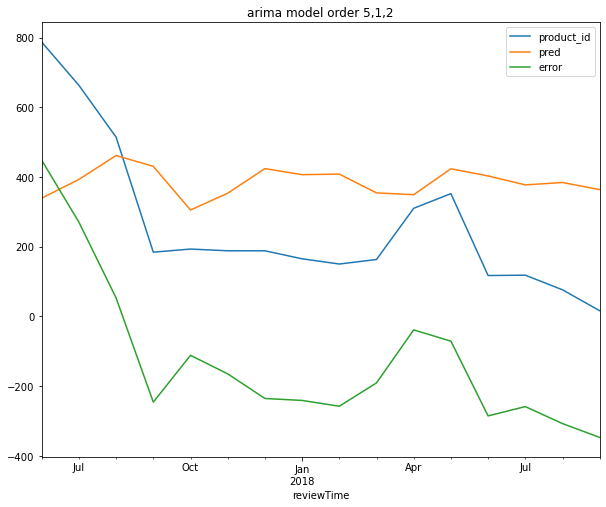

In [409]:
test.product_id.plot(figsize=(10,8),legend=True)
test.pred.plot(legend=True)
test['error'].plot(legend=True)
plt.title(f"arima model order {5},{1},{2}")

### For Neutral Sentiments

for neutral--q=1,p=2,d=1

In [410]:
df_ne.drop('diff_1',axis=1,inplace=True)

In [411]:
ss = int(0.7 * len(df_ne))

train_ne = df_ne.iloc[:ss]
test_ne = df_ne.iloc[ss:]
print("train = {}, test = {}".format(len(train_ne), len(test_ne)))

train = 60, test = 27


In [412]:
for i in range(1,4):
    for j in range(1,3):
        for k in range(1,3):
            m2 = ARIMA(train_ne,order=(i,k,j)).fit()
            print(f"aic is {m2.aic} and bic is {m2.bic} for model with p,d and q as {i},{k} and {j}")
            ljung_box(m2)
            print("-------------------------------------------------------------------------")  

aic is 351.83685502049826 and bic is 358.06946735221544 for model with p,d and q as 1,1 and 1
Fail-to-Reject H0. Good model
-------------------------------------------------------------------------
aic is 360.3070999797859 and bic is 366.4884290114252 for model with p,d and q as 1,2 and 1
Fail-to-Reject H0. Good model
-------------------------------------------------------------------------
aic is 350.52568920010947 and bic is 358.8358389757324 for model with p,d and q as 1,1 and 2
Fail-to-Reject H0. Good model
-------------------------------------------------------------------------
aic is 353.9108531621755 and bic is 362.1526252043612 for model with p,d and q as 1,2 and 2
Fail-to-Reject H0. Good model
-------------------------------------------------------------------------
aic is 350.82719931088127 and bic is 359.1373490865042 for model with p,d and q as 2,1 and 1
Fail-to-Reject H0. Good model
-------------------------------------------------------------------------
aic is 351.25192

p,d,q=1,1,2 for [neutral] as we got the lower AIC score for these values

### Model Building For Neutral Sentiments

In [413]:
model_arima_ne=ARIMA(train_ne,order=(1,1,2)).fit()
print(model_arima_ne.summary())

                               SARIMAX Results                                
Dep. Variable:             product_id   No. Observations:                   60
Model:                 ARIMA(1, 1, 2)   Log Likelihood                -171.263
Date:                Mon, 16 Jan 2023   AIC                            350.526
Time:                        15:40:43   BIC                            358.836
Sample:                    04-30-2011   HQIC                           353.770
                         - 03-31-2016                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.6703      0.244      2.746      0.006       0.192       1.149
ma.L1         -1.4852      0.228     -6.524      0.000      -1.931      -1.039
ma.L2          0.7019      0.145      4.828      0.0

In [414]:
test_ne.tail()

,product_id
reviewTime,
2018-02-28,5
2018-03-31,4
2018-04-30,13
2018-05-31,14
2018-06-30,9


In [415]:
train_ne.tail()

,product_id
reviewTime,
2015-11-30,19
2015-12-31,13
2016-01-31,12
2016-02-29,11
2016-03-31,16


### Doing the Prediction for Neutral Sentiments

In [416]:
start=len(train_ne)
end=len(train_ne)+len(test_ne)-1
print(start,end)
predictions_ne = model_arima_ne.predict(start,end)
print(predictions_ne)

60 86
2016-04-30    12.703692
2016-05-31    12.953180
2016-06-30    13.120404
2016-07-31    13.232490
2016-08-31    13.307618
2016-09-30    13.357974
2016-10-31    13.391726
2016-11-30    13.414349
2016-12-31    13.429513
2017-01-31    13.439677
2017-02-28    13.446489
2017-03-31    13.451056
2017-04-30    13.454116
2017-05-31    13.456168
2017-06-30    13.457543
2017-07-31    13.458464
2017-08-31    13.459082
2017-09-30    13.459496
2017-10-31    13.459774
2017-11-30    13.459960
2017-12-31    13.460084
2018-01-31    13.460168
2018-02-28    13.460224
2018-03-31    13.460261
2018-04-30    13.460287
2018-05-31    13.460303
2018-06-30    13.460315
Freq: M, Name: predicted_mean, dtype: float64


In [417]:
test_ne['pred']=predictions_ne

In [418]:
test_ne['error']=test_ne['product_id']-test_ne['pred']

In [419]:
mse1 = mean_squared_error(test_ne.product_id,test_ne.pred)
print(f"rmse value is {np.sqrt(mse1)}")

rmse value is 5.564350947448665


Text(0.5, 1.0, 'arima model order 1,1,2')

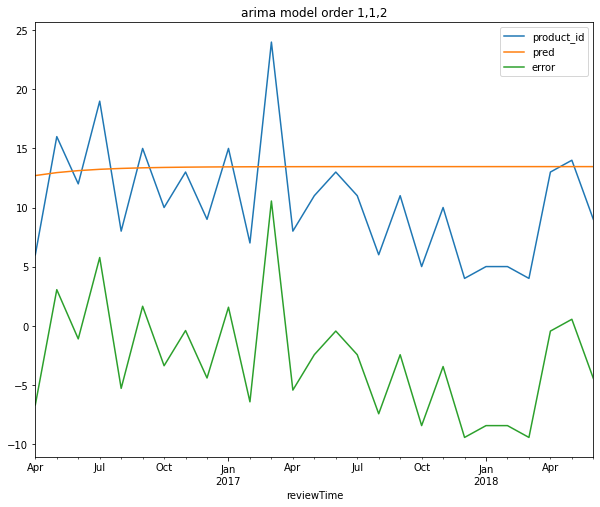

In [420]:
test_ne.product_id.plot(figsize=(10,8),legend=True)
test_ne.pred.plot(legend=True)
test_ne['error'].plot(legend=True)
plt.title(f"arima model order {1},{1},{2}")

### For Negative Sentiments

In [ ]:
#for negative-q=1,p=2,d=1

In [421]:
df_nd.drop('diff_1',axis=1,inplace=True)

In [422]:
ss = int(0.7 * len(df_nd))
train_nd = df_nd.iloc[:ss]
test_nd = df_nd.iloc[ss:]
print("train = {}, test = {}".format(len(train_nd), len(test_nd)))


train = 90, test = 39


In [423]:
for i in range(1,4):
    for j in range(1,3):
        for k in range(1,3):
            m3 = ARIMA(train_nd,order=(i,k,j)).fit()
            print(f"aic is {m3.aic} and bic is {m3.bic} for model with p,d and q as {i},{k} and {j}")
            ljung_box(m3)
            print("-------------------------------------------------------------------------")  

aic is 567.467793246469 and bic is 574.9337023556654 for model with p,d and q as 1,1 and 1
Fail-to-Reject H0. Good model
-------------------------------------------------------------------------
aic is 586.6294704608255 and bic is 594.0614809042601 for model with p,d and q as 1,2 and 1
Fail-to-Reject H0. Good model
-------------------------------------------------------------------------
aic is 569.5050072456792 and bic is 579.4595527246078 for model with p,d and q as 1,1 and 2
Fail-to-Reject H0. Good model
-------------------------------------------------------------------------
aic is 557.4912066868135 and bic is 567.4005539447263 for model with p,d and q as 1,2 and 2
Fail-to-Reject H0. Good model
-------------------------------------------------------------------------
aic is 567.900763624846 and bic is 577.8553091037746 for model with p,d and q as 2,1 and 1
Fail-to-Reject H0. Good model
-------------------------------------------------------------------------
aic is 582.16425747530

p,d,q=1,2,2 for [negative] as we got the lower AIC score for these values

### Model Building For Negative Sentiments

In [424]:
model_arima_nd=ARIMA(train_nd,order=(1,2,2)).fit()
print(model_arima_nd.summary())

                               SARIMAX Results                                
Dep. Variable:             product_id   No. Observations:                   90
Model:                 ARIMA(1, 2, 2)   Log Likelihood                -274.746
Date:                Mon, 16 Jan 2023   AIC                            557.491
Time:                        15:41:18   BIC                            567.401
Sample:                    01-31-2008   HQIC                           561.483
                         - 06-30-2015                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0599      0.086      0.695      0.487      -0.109       0.229
ma.L1         -1.9324      0.052    -37.016      0.000      -2.035      -1.830
ma.L2          0.9701      0.053     18.168      0.0

### Doing the Prediction for Negative Sentiments

In [425]:
start=len(train_nd)
end=len(train_nd)+len(test_nd)-1
print(start,end)
predictions_nd = model_arima_nd.predict(start,end)
print(predictions_nd)

90 128
2015-07-31    29.802294
2015-08-31    30.500016
2015-09-30    30.652104
2015-10-31    30.771493
2015-11-30    30.888922
2015-12-31    31.006234
2016-01-31    31.123538
2016-02-29    31.240842
2016-03-31    31.358146
2016-04-30    31.475450
2016-05-31    31.592755
2016-06-30    31.710059
2016-07-31    31.827363
2016-08-31    31.944667
2016-09-30    32.061971
2016-10-31    32.179275
2016-11-30    32.296579
2016-12-31    32.413883
2017-01-31    32.531187
2017-02-28    32.648491
2017-03-31    32.765795
2017-04-30    32.883099
2017-05-31    33.000403
2017-06-30    33.117707
2017-07-31    33.235011
2017-08-31    33.352316
2017-09-30    33.469620
2017-10-31    33.586924
2017-11-30    33.704228
2017-12-31    33.821532
2018-01-31    33.938836
2018-02-28    34.056140
2018-03-31    34.173444
2018-04-30    34.290748
2018-05-31    34.408052
2018-06-30    34.525356
2018-07-31    34.642660
2018-08-31    34.759964
2018-09-30    34.877268
Freq: M, Name: predicted_mean, dtype: float64


In [427]:
test_nd['pred']=predictions_nd

In [428]:
test_nd['error']=test_nd['product_id']-test_nd['pred']

In [429]:
mse1 = mean_squared_error(test_nd.product_id,test_nd.pred)
print(f"rmse value is {np.sqrt(mse1)}")

rmse value is 15.128900181150593


Text(0.5, 1.0, 'arima model order 1,2,2')

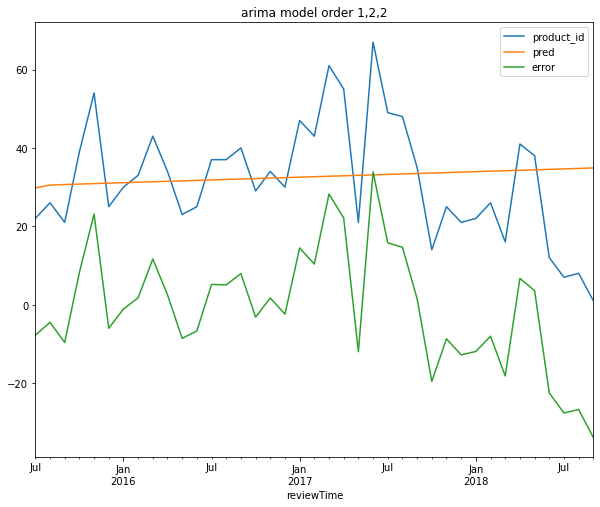

In [430]:
test_nd.product_id.plot(figsize=(10,8),legend=True)
test_nd.pred.plot(legend=True)
test_nd['error'].plot(legend=True)
plt.title(f"arima model order {1},{2},{2}")

## SARIMAX Model

### For Positive Sentiments

In [431]:
checkStationarity(d_seasonal_p)

'p-value=0.0. Data is stationary'

### Plotting the graph for finding the value of p and q

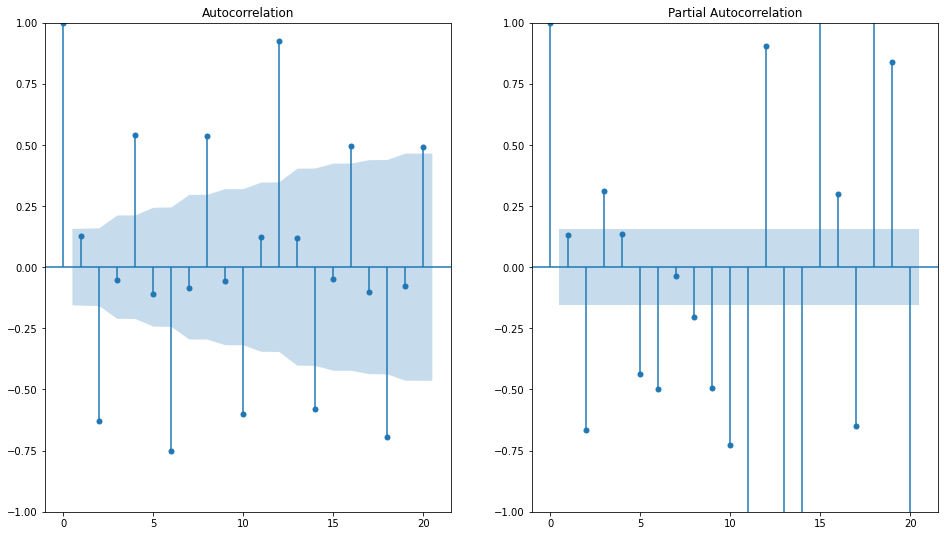

In [432]:
fig,ax=plt.subplots(1,2,figsize=(16,9))
plot_acf(d_seasonal_p,lags=20,ax=ax[0])  
plot_pacf(d_seasonal_p,lags=20,ax=ax[1])  
plt.show()

We found D=0,P=0,Q=0

### Model Building

In [433]:
model_sarima_p = SARIMAX(train, order=(5,2,1), seasonal_order=(0,0,0,12)).fit()
print(model_sarima_p.summary())

                               SARIMAX Results                                
Dep. Variable:             product_id   No. Observations:                  141
Model:               SARIMAX(5, 2, 1)   Log Likelihood                -765.021
Date:                Mon, 16 Jan 2023   AIC                           1544.042
Time:                        15:42:23   BIC                           1564.583
Sample:                    09-30-2005   HQIC                          1552.389
                         - 05-31-2017                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.7510      0.063    -11.940      0.000      -0.874      -0.628
ar.L2         -0.9041      0.070    -12.826      0.000      -1.042      -0.766
ar.L3         -0.7860      0.084     -9.362      0.0

In [434]:
test.head()

,product_id,pred,error
reviewTime,,,
2017-06-30,787,339.013322,447.986678
2017-07-31,663,392.841409,270.158591
2017-08-31,514,461.426801,52.573199
2017-09-30,184,430.353338,-246.353338
2017-10-31,193,305.039503,-112.039503


In [435]:
test.tail(1)

,product_id,pred,error
reviewTime,,,
2018-09-30,16,363.687279,-347.687279


### Doing the Prediction

In [436]:
start=len(train)
end=len(train)+len(test)-1
print(start,end)
predictions_sarima = model_sarima_p.predict(start,end)
print(predictions_sarima)

141 156
2017-06-30    384.898685
2017-07-31    452.425139
2017-08-31    469.173085
2017-09-30    454.823866
2017-10-31    388.957492
2017-11-30    383.718205
2017-12-31    446.040399
2018-01-31    475.988301
2018-02-28    461.251229
2018-03-31    433.438995
2018-04-30    423.787946
2018-05-31    448.725782
2018-06-30    477.475895
2018-07-31    477.905533
2018-08-31    461.500859
2018-09-30    454.408761
Freq: M, Name: predicted_mean, dtype: float64


In [437]:
test['pred_sarima']=predictions_sarima

In [438]:
test['error_sarima']=test['product_id']-test['pred_sarima']

In [439]:
mse_sarima = mean_squared_error(test.product_id,test.pred_sarima)
print(f"rmse value is {np.sqrt(mse_sarima)}")

rmse value is 286.5737198975648


Text(0.5, 1.0, 'sarima model order 5,2,1,0,0,0,12')

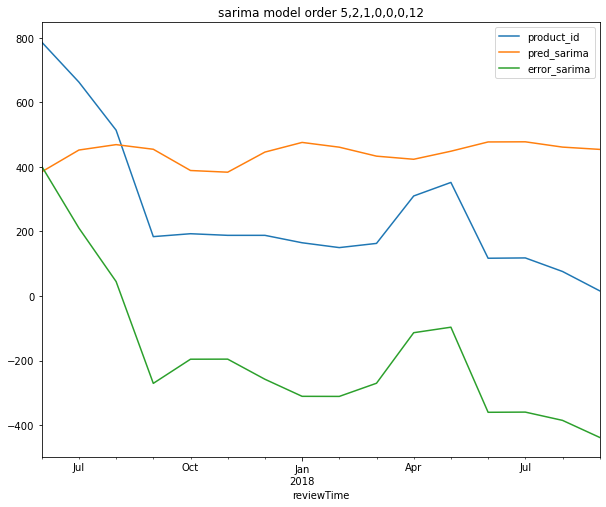

In [440]:
test.product_id.plot(figsize=(10,8),legend=True)
test.pred_sarima.plot(legend=True)
test['error_sarima'].plot(legend=True)
plt.title(f"sarima model order {5},{2},{1},{0},{0},{0},{12}")

### For Negative Sentiments


In [441]:
#negative
checkStationarity(d_seasonal_n)

'p-value=0.0. Data is stationary'

### Plotting the graph for finding the value of p and q

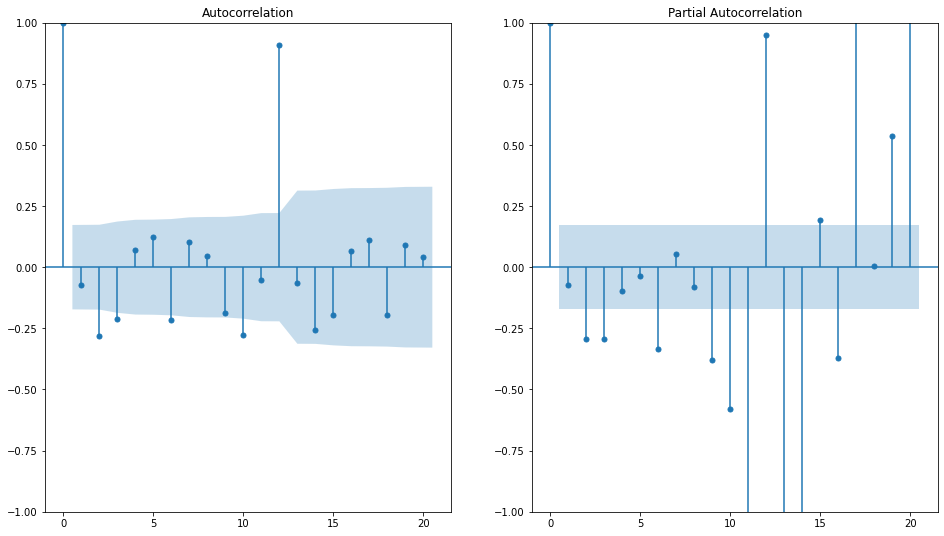

In [442]:
fig,ax=plt.subplots(1,2,figsize=(16,9))
plot_acf(d_seasonal_n,lags=20,ax=ax[0])  
plot_pacf(d_seasonal_n,lags=20,ax=ax[1])  
plt.show()

We found P=0,D=0,Q=0

### Model Building

In [443]:
model_sarima_nd = SARIMAX(train_nd, order=(2,1,1), seasonal_order=(0,0,0,12)).fit()
print(model_sarima_nd.summary())

                               SARIMAX Results                                
Dep. Variable:             product_id   No. Observations:                   90
Model:               SARIMAX(2, 1, 1)   Log Likelihood                -279.950
Date:                Mon, 16 Jan 2023   AIC                            567.901
Time:                        15:42:55   BIC                            577.855
Sample:                    01-31-2008   HQIC                           571.913
                         - 06-30-2015                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0165      0.111     -0.148      0.882      -0.235       0.202
ar.L2         -0.1534      0.079     -1.951      0.051      -0.307       0.001
ma.L1         -0.6903      0.092     -7.486      0.0

In [444]:
print(test_nd.head(2))
print(test_nd.tail(2))

            product_id       pred     error
reviewTime                                 
2015-07-31          22  29.802294 -7.802294
2015-08-31          26  30.500016 -4.500016
            product_id       pred      error
reviewTime                                  
2018-08-31           8  34.759964 -26.759964
2018-09-30           1  34.877268 -33.877268


### Doing the Prediction

In [445]:
start=len(train_nd)
end=len(train_nd)+len(test_nd)-1
print(start,end)
predictions_sarima_nd = model_sarima_nd.predict(start,end)
print(predictions_sarima_nd)

90 128
2015-07-31    26.132267
2015-08-31    28.791970
2015-09-30    27.807577
2015-10-31    27.415866
2015-11-30    27.573307
2015-12-31    27.630791
2016-01-31    27.605695
2016-02-29    27.597292
2016-03-31    27.601280
2016-04-30    27.602503
2016-05-31    27.601871
2016-06-30    27.601694
2016-07-31    27.601794
2016-08-31    27.601819
2016-09-30    27.601804
2016-10-31    27.601800
2016-11-30    27.601802
2016-12-31    27.601803
2017-01-31    27.601803
2017-02-28    27.601802
2017-03-31    27.601803
2017-04-30    27.601803
2017-05-31    27.601803
2017-06-30    27.601803
2017-07-31    27.601803
2017-08-31    27.601803
2017-09-30    27.601803
2017-10-31    27.601803
2017-11-30    27.601803
2017-12-31    27.601803
2018-01-31    27.601803
2018-02-28    27.601803
2018-03-31    27.601803
2018-04-30    27.601803
2018-05-31    27.601803
2018-06-30    27.601803
2018-07-31    27.601803
2018-08-31    27.601803
2018-09-30    27.601803
Freq: M, Name: predicted_mean, dtype: float64


In [446]:
test_nd.head()

,product_id,pred,error
reviewTime,,,
2015-07-31,22,29.802294,-7.802294
2015-08-31,26,30.500016,-4.500016
2015-09-30,21,30.652104,-9.652104
2015-10-31,39,30.771493,8.228507
2015-11-30,54,30.888922,23.111078


In [447]:
test_nd['pred_sarima']=predictions_sarima_nd

In [448]:
test_nd['error_sarima']=test_nd['product_id']-test_nd['pred_sarima']

In [449]:
mse_sarima_nd = mean_squared_error(test_nd.product_id,test_nd.pred_sarima)
print(f"rmse value is {np.sqrt(mse_sarima_nd)}")

rmse value is 15.263418089568065


In [450]:
test_nd.head()

,product_id,pred,error,pred_sarima,error_sarima
reviewTime,,,,,
2015-07-31,22,29.802294,-7.802294,26.132267,-4.132267
2015-08-31,26,30.500016,-4.500016,28.791970,-2.791970
2015-09-30,21,30.652104,-9.652104,27.807577,-6.807577
2015-10-31,39,30.771493,8.228507,27.415866,11.584134
2015-11-30,54,30.888922,23.111078,27.573307,26.426693


Text(0.5, 1.0, 'sarima model order 2,1,1,0,0,0,12')

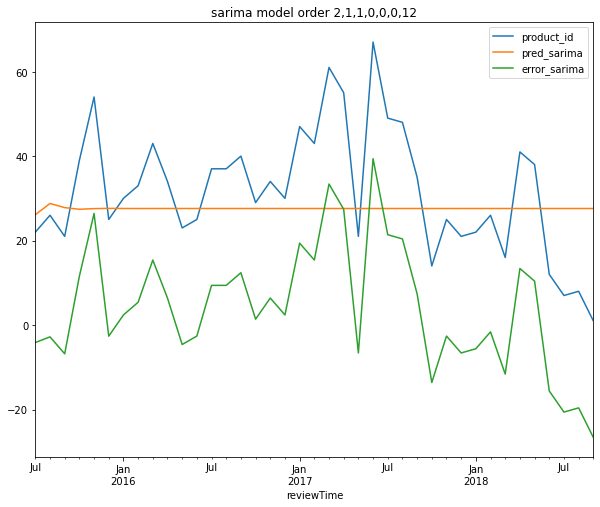

In [451]:
test_nd.product_id.plot(figsize=(10,8),legend=True)
test_nd.pred_sarima.plot(legend=True)
test_nd['error_sarima'].plot(legend=True)
plt.title(f"sarima model order {2},{1},{1},{0},{0},{0},{12}")

### For Neutral Sentiments

In [452]:
#neutral
checkStationarity(d_seasonal)

'p-value=0.0. Data is stationary'

### Plotting the graph for finding the value of p and q

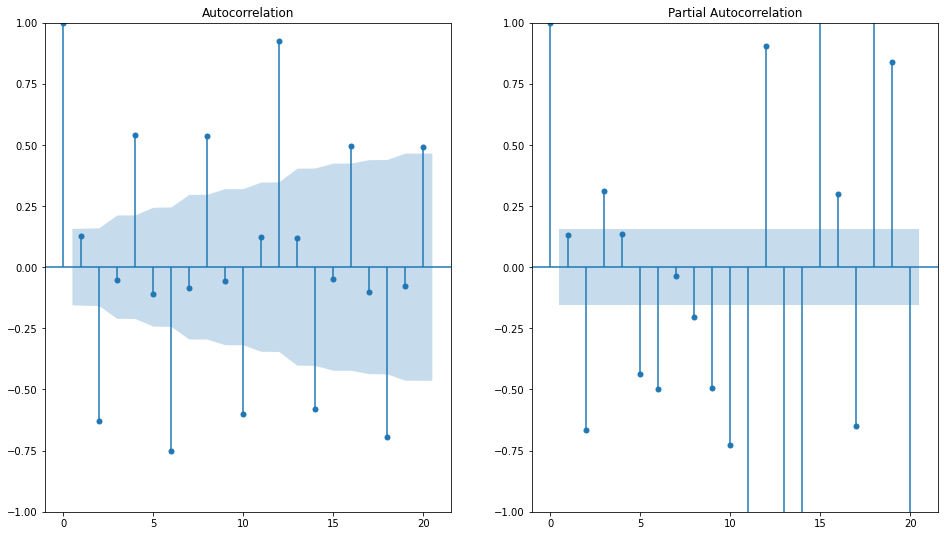

In [453]:
fig,ax=plt.subplots(1,2,figsize=(16,9))
plot_acf(d_seasonal_p,lags=20,ax=ax[0])  
plot_pacf(d_seasonal_p,lags=20,ax=ax[1])  
plt.show()

We got P=0,Q=0,D=0

In [454]:
test_ne.head()

,product_id,pred,error
reviewTime,,,
2016-04-30,6,12.703692,-6.703692
2016-05-31,16,12.953180,3.046820
2016-06-30,12,13.120404,-1.120404
2016-07-31,19,13.232490,5.767510
2016-08-31,8,13.307618,-5.307618


### Model Building

In [455]:
model_sarima_ne = SARIMAX(train_ne, order=(2,1,1), seasonal_order=(0,0,0,12)).fit()
print(model_sarima_ne.summary())

                               SARIMAX Results                                
Dep. Variable:             product_id   No. Observations:                   60
Model:               SARIMAX(2, 1, 1)   Log Likelihood                -171.414
Date:                Mon, 16 Jan 2023   AIC                            350.827
Time:                        15:43:36   BIC                            359.137
Sample:                    04-30-2011   HQIC                           354.071
                         - 03-31-2016                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.5487      0.262     -2.097      0.036      -1.062      -0.036
ar.L2         -0.3469      0.160     -2.165      0.030      -0.661      -0.033
ma.L1         -0.1798      0.226     -0.794      0.4

In [456]:
print(test_ne.head(2))
print(test_ne.tail(2))

            product_id       pred     error
reviewTime                                 
2016-04-30           6  12.703692 -6.703692
2016-05-31          16  12.953180  3.046820
            product_id       pred     error
reviewTime                                 
2018-05-31          14  13.460303  0.539697
2018-06-30           9  13.460315 -4.460315


### Doing Prediction

In [457]:
start=len(train_ne)
end=len(train_ne)+len(test_ne)-1
print(start,end)
predictions_sarima_ne= model_sarima_ne.predict(start,end)
print(predictions_sarima_ne)

60 86
2016-04-30    12.989534
2016-05-31    12.906952
2016-06-30    13.996623
2016-07-31    13.427327
2016-08-31    13.361706
2016-09-30    13.595208
2016-10-31    13.489841
2016-11-30    13.466656
2016-12-31    13.515931
2017-01-31    13.496935
2017-02-28    13.490265
2017-03-31    13.500515
2017-04-30    13.497204
2017-05-31    13.495465
2017-06-30    13.497568
2017-07-31    13.497018
2017-08-31    13.496590
2017-09-30    13.497016
2017-10-31    13.496931
2017-11-30    13.496830
2017-12-31    13.496915
2018-01-31    13.496903
2018-02-28    13.496880
2018-03-31    13.496897
2018-04-30    13.496895
2018-05-31    13.496890
2018-06-30    13.496894
Freq: M, Name: predicted_mean, dtype: float64


In [458]:
test_ne['pred_sarima']=predictions_sarima_ne

In [459]:
test_ne['error_sarima']=test_ne['product_id']-test_ne['pred_sarima']

In [460]:
mse_sarima_ne= mean_squared_error(test_ne.product_id,test_ne.pred_sarima)
print(f"rmse value is {np.sqrt(mse_sarima_ne)}")

rmse value is 5.600539270466473


In [461]:
test_ne.head(2)

,product_id,pred,error,pred_sarima,error_sarima
reviewTime,,,,,
2016-04-30,6,12.703692,-6.703692,12.989534,-6.989534
2016-05-31,16,12.953180,3.046820,12.906952,3.093048


Text(0.5, 1.0, 'sarima model order 2,1,1,0,0,0,12')

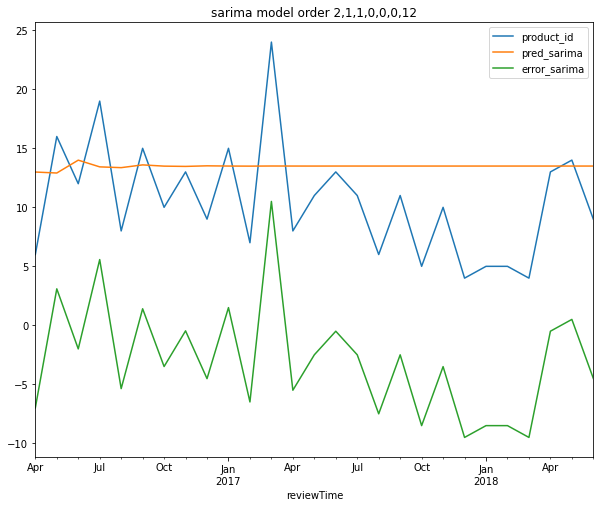

In [462]:
test_ne.product_id.plot(figsize=(10,8),legend=True)
test_ne.pred_sarima.plot(legend=True)
test_ne['error_sarima'].plot(legend=True)
plt.title(f"sarima model order {2},{1},{1},{0},{0},{0},{12}")

#### WE ARE USING ARIMA MODEL FOR FORECASTING SINCE IT HAS LOW  RMSE VALUE

## Doing the Forecasting by using our better(ARIMA) model

### For Positive

In [464]:
test.tail(1)

,product_id,pred,error,pred_sarima,error_sarima
reviewTime,,,,,
2018-09-30,16,363.687279,-347.687279,454.408761,-438.408761


In [466]:
df_pd.head()

,product_id
reviewTime,
2005-09-30,1
2005-10-31,0
2005-11-30,0
2005-12-31,0
2006-01-31,0


In [467]:
fcast = model_arima.predict(start=len(df_pd), end=len(df_pd)+20).rename('forecast')
print(fcast)

2018-10-31    398.996190
2018-11-30    411.123165
2018-12-31    369.228299
2019-01-31    382.260133
2019-02-28    387.296772
2019-03-31    381.975096
2019-04-30    404.043558
2019-05-31    382.029702
2019-06-30    372.587406
2019-07-31    396.041722
2019-08-31    385.005077
2019-09-30    387.875040
2019-10-31    392.815399
2019-11-30    374.737874
2019-12-31    388.769313
2020-01-31    394.008441
2020-02-29    380.535726
2020-03-31    390.299659
2020-04-30    385.286117
2020-05-31    381.223403
2020-06-30    394.420773
Freq: M, Name: forecast, dtype: float64


<AxesSubplot:xlabel='reviewTime'>

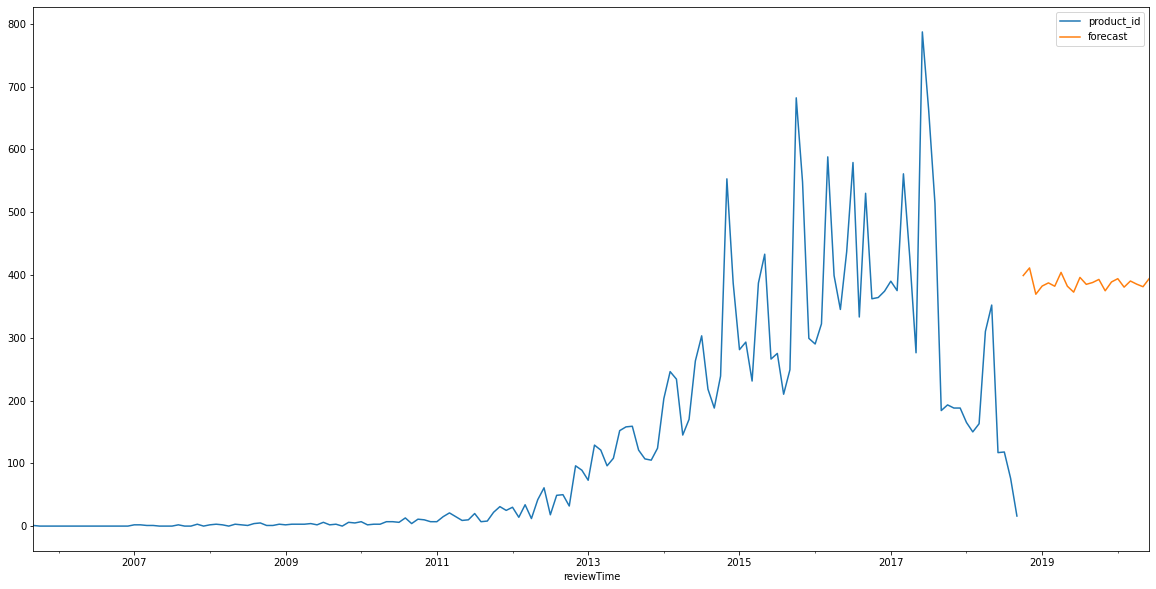

In [468]:
df_pd.plot(figsize=(20,10),legend=True)
fcast.plot(legend=True)

### For Neutral

In [469]:
fcast_ne = model_arima_ne.predict(start=len(df_ne), end=len(df_ne)+20).rename('forecast')
print(fcast_ne)

2018-07-31    13.460322
2018-08-31    13.460327
2018-09-30    13.460331
2018-10-31    13.460333
2018-11-30    13.460335
2018-12-31    13.460336
2019-01-31    13.460336
2019-02-28    13.460337
2019-03-31    13.460337
2019-04-30    13.460337
2019-05-31    13.460337
2019-06-30    13.460338
2019-07-31    13.460338
2019-08-31    13.460338
2019-09-30    13.460338
2019-10-31    13.460338
2019-11-30    13.460338
2019-12-31    13.460338
2020-01-31    13.460338
2020-02-29    13.460338
2020-03-31    13.460338
Freq: M, Name: forecast, dtype: float64


<AxesSubplot:xlabel='reviewTime'>

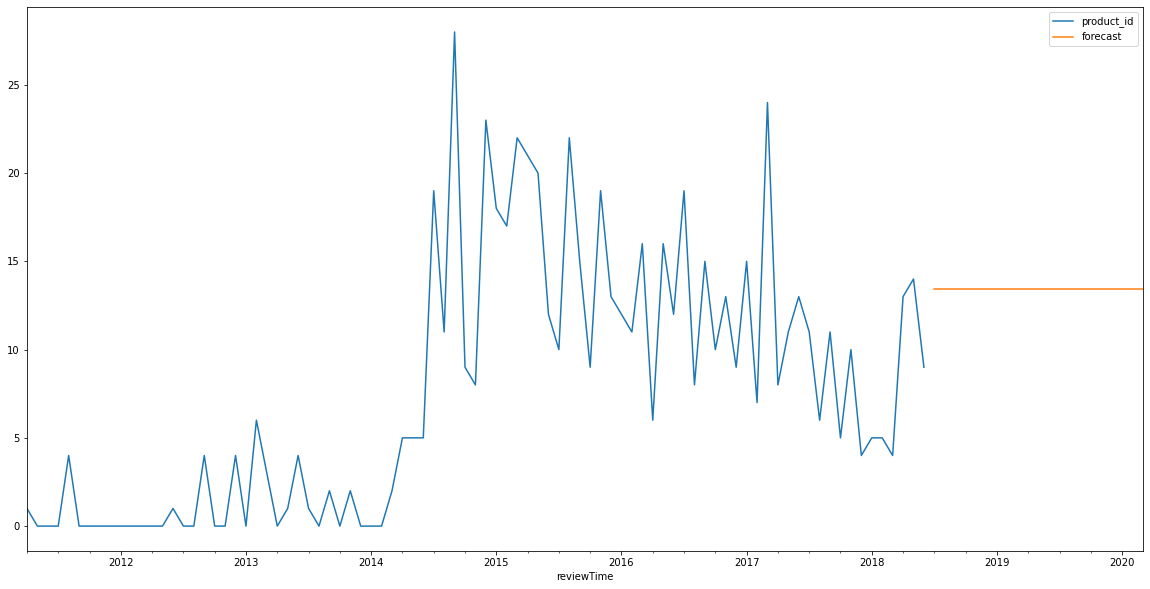

In [470]:
df_ne.plot(figsize=(20,10),legend=True)
fcast_ne.plot(legend=True)

### For Negative

In [473]:
fcast_nd = model_arima_nd.predict(start=len(df_nd), end=len(df_nd)+20).rename('forecast')
print(fcast_nd)

2018-10-31    34.994572
2018-11-30    35.111877
2018-12-31    35.229181
2019-01-31    35.346485
2019-02-28    35.463789
2019-03-31    35.581093
2019-04-30    35.698397
2019-05-31    35.815701
2019-06-30    35.933005
2019-07-31    36.050309
2019-08-31    36.167613
2019-09-30    36.284917
2019-10-31    36.402221
2019-11-30    36.519525
2019-12-31    36.636829
2020-01-31    36.754133
2020-02-29    36.871438
2020-03-31    36.988742
2020-04-30    37.106046
2020-05-31    37.223350
2020-06-30    37.340654
Freq: M, Name: forecast, dtype: float64


<AxesSubplot:xlabel='reviewTime'>

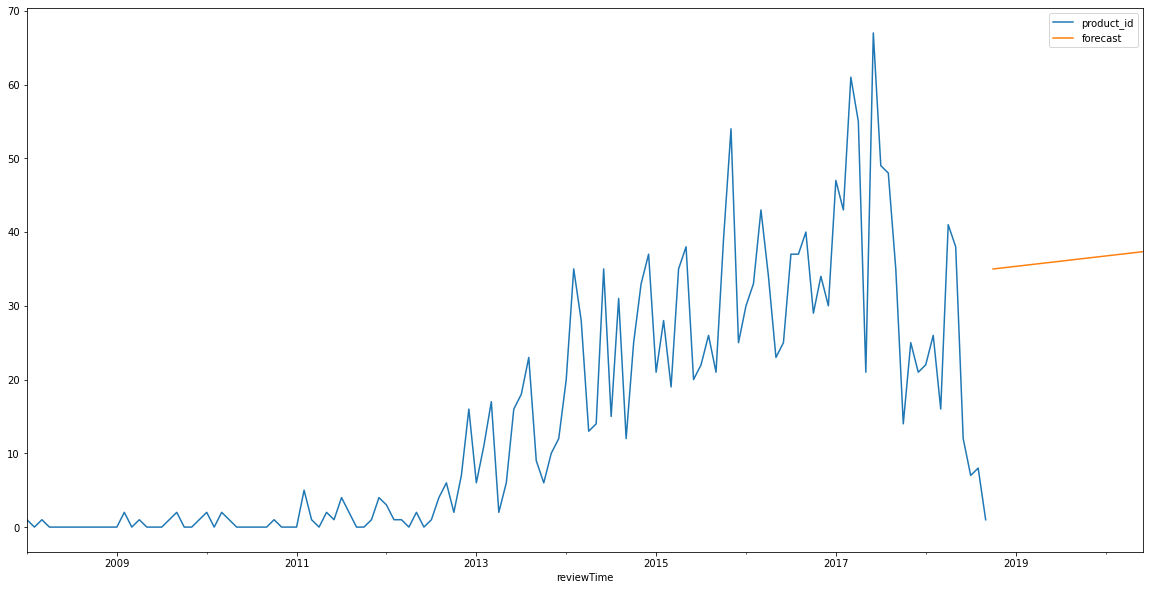

In [474]:
df_nd.plot(figsize=(20,10),legend=True)
fcast_nd.plot(legend=True)